# Trial 2

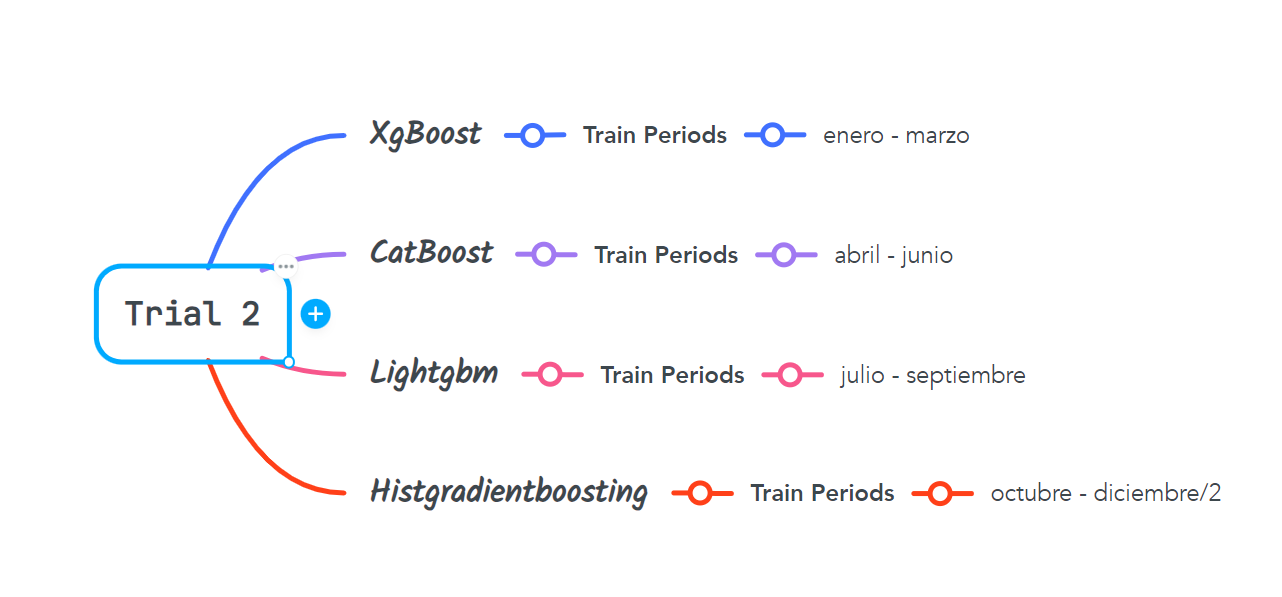



In [ ]:
!pip install ta
!pip install catboost
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import calendar
import numpy as np
#from google.colab import data_table
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import PowerTransformer
from scipy import stats
import ta
from scipy.stats import mstats
from sklearn.metrics import make_scorer
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import statsmodels.stats.diagnostic as smd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, chi2, SelectFromModel, VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, VarianceThreshold
from sklearn.feature_selection import RFE
from sklearn.ensemble import VotingRegressor
from sklearn.feature_selection import SelectKBest, f_regression,SelectPercentile
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.tree import DecisionTreeRegressor
import pickle
from sklearn.feature_selection import RFE

# Global functions-code-util



In [ ]:
#features for all models - use in flask with no changes
selected_feature_names = [
        'topWick',
        'body',
        'bottomWick',
        'spread',
        'hour',
        'day',
        'month',
        'body_3',
        'body_5',
        'body_20',
        'ticks_2',
        'ticks_4',
        'ticks_5',
        'ticks_15',
        'ticks_60',
        'spread_5',
        'spread_log',
        'body_log',
        'ticks_log',
        'spread_sqrt',
        'body_sqrt',
]

In [ ]:
#times for lags
one_min = -60
two_min = -120
three_min = -180
four_min = -240
five_min = -300
ten_min = -600
fifteen_min = -900
twenty_min = -1200
twentyfive_min = -1500
thirty_min = -1800
fourty_min = -2400
sixty_min = -3600

# 2022 Dataset

In [ ]:
df_full_2022 = pd.read_csv('/content/drive/MyDrive/monobot/DeafReload/ExportedSecBarData 2022.csv',delimiter=";",header=None)
print(df_full_2022.shape)

(11670861, 11)


In [ ]:
df_full_2022.rename(columns={0: "timestamp_column", 1: "open", 2: "high", 3: "low", 4: "close", 5: "ticks", 6: "spread", 7: "direction", 8: "topWick", 9: "body",10: "bottomWick"}, inplace=True)
print(df_full_2022.shape)

(11670861, 11)


In [ ]:
df_full_2022.iloc[:, [0]] = pd.to_datetime(df_full_2022['timestamp_column'])

<ipython-input-6-1ccb3ad8f5c7>:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_full_2022.iloc[:, [0]] = pd.to_datetime(df_full_2022['timestamp_column'])


In [ ]:
#logs
df_full_2022['close_log'] = np.log(df_full_2022['close'])
df_full_2022['open_log'] = np.log(df_full_2022['open'])

In [ ]:
#add Y_5 to 2022 dataset
df_full_2022['Y_5_log_1'] = (df_full_2022['close_log']*10000).shift(-300) - (df_full_2022['open_log']*10000)
df_full_2022['Y_5'] = (df_full_2022['close']*10000).shift(-300) - (df_full_2022['open']*10000)

In [ ]:
#transformation
df_full_2022['signed_sqrt_Y_5'] = np.sign(df_full_2022['Y_5']) * np.sqrt(np.abs(df_full_2022['Y_5']))

# 2023 Dataset

In [ ]:
df_full_2023 = pd.read_csv('/content/drive/MyDrive/monobot/DeafReload/Merged_Data.csv',
                      usecols=['datetime','open','high','low','close','ticks','spread','direction','topWick','body','bottomWick','Y_5'])

In [ ]:
df_full_2023.rename(columns={"datetime": "timestamp_column"}, inplace=True)

In [ ]:
df_full_2023.iloc[:, [0]] = pd.to_datetime(df_full_2023['timestamp_column'])

<ipython-input-12-fe6e3f81a00e>:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_full_2023.iloc[:, [0]] = pd.to_datetime(df_full_2023['timestamp_column'])


In [ ]:
#logs
df_full_2023['close_log'] = np.log(df_full_2023['close'])
df_full_2023['open_log'] = np.log(df_full_2023['open'])

In [ ]:
df_full_2023['Y_5_log_1'] = (df_full_2023['close_log']*10000).shift(-300) - (df_full_2023['open_log']*10000)

In [ ]:
#transformation
df_full_2023['signed_sqrt_Y_5'] = np.sign(df_full_2023['Y_5']) * np.sqrt(np.abs(df_full_2023['Y_5']))

In [ ]:
df_full_2023.head(1)

,timestamp_column,direction,topWick,body,bottomWick,ticks,spread,open,high,low,close,Y_5,close_log,open_log,Y_5_log_1,signed_sqrt_Y_5
0,2023-01-03 05:42:41,'D',0,1,0,2,9,1.06749,1.06749,1.06748,1.06748,-2.4,0.065301,0.06531,-2.248517,-1.549193


# Concat 2022-2023

In [ ]:
# prompt: iloc specific features in df_full
df_2022 = df_full_2022.iloc[:, [0,1,2,3,4,5,6,8,9,10,13,14,15]]
print(df_2022.shape)

(11670861, 13)


In [ ]:
df_2022.head(1)

,timestamp_column,open,high,low,close,ticks,spread,topWick,body,bottomWick,Y_5_log_1,Y_5,signed_sqrt_Y_5
0,2022-01-03 18:46:02,1.12881,1.12882,1.12881,1.12882,2,9.0,0,0,0,-1.240321,-1.4,-1.183216


In [ ]:
df_2023 = df_full_2023.iloc[:, [0,7,8,9,10,5,6,2,3,4,14,11,15]]
print(df_2023.shape)

(9811696, 13)


In [ ]:
df_2023.head(1)

,timestamp_column,open,high,low,close,ticks,spread,topWick,body,bottomWick,Y_5_log_1,Y_5,signed_sqrt_Y_5
0,2023-01-03 05:42:41,1.06749,1.06749,1.06748,1.06748,2,9,0,1,0,-2.248517,-2.4,-1.549193


In [ ]:
# prompt: concat def_2022 and df_2023
df_22_23_concat = pd.concat([df_2022, df_2023])
print(df_22_23_concat.shape)

(21482557, 13)


# Full - DataBase

In [ ]:
df_22_23 = df_22_23_concat.dropna()

In [ ]:
df_22_23.head(1)

,timestamp_column,open,high,low,close,ticks,spread,topWick,body,bottomWick,Y_5_log_1,Y_5,signed_sqrt_Y_5
0,2022-01-03 18:46:02,1.12881,1.12882,1.12881,1.12882,2,9.0,0,0,0,-1.240321,-1.4,-1.183216


In [ ]:
print('Full Data No missing values',df_22_23.shape)

Full Data No missing values (21481957, 13)


# Non-Seen DataBase Test
- data base only for test final models

In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/monobot/DeafReload/test_data/ExportedSecBarData.csv',low_memory=False,delimiter=';',header=None)
print(test_data.shape)


(725457, 11)


In [ ]:
#test_data = pd.read_csv('/content/drive/MyDrive/monobot/data/TestData_202312_202401.csv',low_memory=False,delimiter=';',header=None)
#print(test_data.shape)

In [ ]:
#rename columns
test_data.rename(columns={0: "timestamp_column", 1: "open", 2: "high", 3: "low", 4: "close", 5: "ticks", 6: "spread", 7: "direction", 8: "topWick", 9: "body",10: "bottomWick"}, inplace=True)
print(test_data.head(5))

      timestamp_column     open     high      low    close  ticks  spread  \
0  2023.12.21 16:40:08  1.09966  1.09969  1.09966  1.09966      7    12.0   
1  2023.12.21 16:40:09  1.09965  1.09970  1.09965  1.09970      6    10.0   
2  2023.12.21 16:40:10  1.09969  1.09969  1.09967  1.09967      2     2.0   
3  2023.12.21 16:40:11  1.09966  1.09966  1.09965  1.09965      2     4.0   
4  2023.12.21 16:40:12  1.09964  1.09966  1.09962  1.09966      6     8.0   

  direction  topWick  body  bottomWick  
0       'N'        2     0           0  
1       'U'        0     4           0  
2       'D'        0     2           0  
3       'D'        0     1           0  
4       'U'        0     2           1  


In [ ]:
#convert datatime to_datetime
test_data['timestamp_column'] = pd.to_datetime(test_data['timestamp_column'])

In [ ]:
#logs
test_data['close_log'] = np.log(test_data['close'])
test_data['open_log'] = np.log(test_data['open'])

In [ ]:
#target
test_data['Y_5'] = (test_data['close']*10000).shift(-300) - (test_data['open']*10000)
test_data['Y_5_log_1'] = (test_data['close_log']*10000).shift(-300) - (test_data['open_log']*10000)
test_data['signed_sqrt_Y_5'] = np.sign(test_data['Y_5']) * np.sqrt(np.abs(test_data['Y_5']))

# ***Build Feat Test Data***

In [ ]:
# prompt: create new featires from datetime variable
test_data['hour'] = test_data['timestamp_column'].apply(lambda x: x.hour)
test_data['day'] = test_data['timestamp_column'].apply(lambda x: x.day)
test_data['month'] = test_data['timestamp_column'].apply(lambda x: x.month)

In [ ]:
# prompt: create lags from body, ticks and spead features
test_data['body_1'] = test_data['body'].shift(one_min)
test_data['body_2'] = test_data['body'].shift(two_min)
test_data['body_3'] = test_data['body'].shift(three_min)
test_data['body_4'] = test_data['body'].shift(four_min)
test_data['body_5'] = test_data['body'].shift(five_min)
test_data['body_10'] = test_data['body'].shift(ten_min)
test_data['body_15'] = test_data['body'].shift(fifteen_min)
test_data['body_20'] = test_data['body'].shift(twenty_min)
test_data['body_25'] = test_data['body'].shift(twentyfive_min)
test_data['body_30'] = test_data['body'].shift(thirty_min)
test_data['body_40'] = test_data['body'].shift(fourty_min)
test_data['body_60'] = test_data['body'].shift(sixty_min)

In [ ]:
#for ticks
test_data['ticks_1'] = test_data['ticks'].shift(one_min)
test_data['ticks_2'] = test_data['ticks'].shift(two_min)
test_data['ticks_3'] = test_data['ticks'].shift(three_min)
test_data['ticks_4'] = test_data['ticks'].shift(four_min)
test_data['ticks_5'] = test_data['ticks'].shift(five_min)
test_data['ticks_10'] = test_data['ticks'].shift(ten_min)
test_data['ticks_15'] = test_data['ticks'].shift(fifteen_min)
test_data['ticks_20'] = test_data['ticks'].shift(twenty_min)
test_data['ticks_25'] = test_data['ticks'].shift(twentyfive_min)
test_data['ticks_30'] = test_data['ticks'].shift(thirty_min)
test_data['ticks_40'] = test_data['ticks'].shift(fourty_min)
test_data['ticks_60'] = test_data['ticks'].shift(sixty_min)

In [ ]:
#for spread
test_data['spread_1'] = test_data['spread'].shift(one_min)
test_data['spread_2'] = test_data['spread'].shift(two_min)
test_data['spread_3'] = test_data['spread'].shift(three_min)
test_data['spread_4'] = test_data['spread'].shift(four_min)
test_data['spread_5'] = test_data['spread'].shift(five_min)
test_data['spread_10'] = test_data['spread'].shift(ten_min)
test_data['spread_15'] = test_data['spread'].shift(fifteen_min)
test_data['spread_20'] = test_data['spread'].shift(twenty_min)
test_data['spread_25'] = test_data['spread'].shift(twentyfive_min)
test_data['spread_30'] = test_data['spread'].shift(thirty_min)
test_data['spread_40'] = test_data['spread'].shift(fourty_min)
test_data['spread_60'] = test_data['spread'].shift(sixty_min)

In [ ]:
# prompt: statistics transformation for spread,body and ticks features
test_data['spread_log'] = np.log(test_data['spread']+1)
test_data['body_log'] = np.log(test_data['body']+1)
test_data['ticks_log'] = np.log(test_data['ticks']+1)

In [ ]:
# prompt: Square Root Transformation for spread,body and ticks
test_data['spread_sqrt'] = np.sqrt(test_data['spread'])
test_data['body_sqrt'] = np.sqrt(test_data['body'])
test_data['ticks_sqrt'] = np.sqrt(test_data['ticks'])

In [ ]:
# prompt: Interaction Terms
test_data['spread_x_body'] = test_data['spread'] * test_data['body']
test_data['spread_x_ticks'] = test_data['spread'] * test_data['ticks']
test_data['body_x_ticks'] = test_data['body'] * test_data['ticks']

In [ ]:
#drop nan
test_data = test_data.dropna()
print(test_data.shape)

(721857, 64)


In [ ]:
print(test_data.timestamp_column.head(1))
print(test_data.timestamp_column.tail(1))

0   2023-12-21 16:40:08
Name: timestamp_column, dtype: datetime64[ns]
721856   2024-01-19 21:14:30
Name: timestamp_column, dtype: datetime64[ns]


# Split data
- split before modeling to avoid data leackage

## Split Xgboost

In [ ]:
#Train/Valid/Test
df_train_full_xg = df_22_23[(df_22_23["timestamp_column"]>=("2022-01-03 18:46:02")) & (df_22_23["timestamp_column"]<="2022-03-31 23:54:50")]

In [ ]:
print(df_train_full_xg.timestamp_column.head(1))
print(df_train_full_xg.timestamp_column.tail(1))

0   2022-01-03 18:46:02
Name: timestamp_column, dtype: datetime64[ns]
2461694   2022-03-31 23:54:48
Name: timestamp_column, dtype: datetime64[ns]


In [ ]:
# prompt: count registers number by timestamp_column in augmented_df group by month
print(df_train_full_xg.groupby(df_train_full_xg['timestamp_column'].dt.month)['timestamp_column'].count())

timestamp_column
1     637779
2     754465
3    1069451
Name: timestamp_column, dtype: int64


## Split Catboost

In [ ]:
#Train/Valid/Test
df_train_full_cb = df_22_23[(df_22_23["timestamp_column"] >= ("2022-04-04 00:00:00")) & (df_22_23["timestamp_column"]<="2022-06-30 23:00:00")]

In [ ]:
print(df_train_full_cb.timestamp_column.head(1))
print(df_train_full_cb.timestamp_column.tail(1))

2502434   2022-04-04 00:05:35
Name: timestamp_column, dtype: datetime64[ns]
5289114   2022-06-30 23:00:00
Name: timestamp_column, dtype: datetime64[ns]


In [ ]:
# prompt: count registers number by timestamp_column in augmented_df group by month
print(df_train_full_cb.groupby(df_train_full_cb['timestamp_column'].dt.month)['timestamp_column'].count())

timestamp_column
4     788094
5     971585
6    1027002
Name: timestamp_column, dtype: int64


## Split Lg

In [ ]:
#Train/Valid/Test
df_train_full_lg = df_22_23[(df_22_23["timestamp_column"] >= ("2022-07-04 00:00:00")) & (df_22_23["timestamp_column"]<="2022-09-30 23:54:50")]

In [ ]:
print(df_train_full_lg.timestamp_column.head(1))
print(df_train_full_lg.timestamp_column.tail(1))

5339637   2022-07-04 00:05:55
Name: timestamp_column, dtype: datetime64[ns]
8341036   2022-09-30 23:54:47
Name: timestamp_column, dtype: datetime64[ns]


In [ ]:
# prompt: count registers number by timestamp_column in augmented_df group by month
print(df_train_full_lg.groupby(df_train_full_lg['timestamp_column'].dt.month)['timestamp_column'].count())

timestamp_column
7     944136
8     976440
9    1080824
Name: timestamp_column, dtype: int64


## Split hist

In [ ]:
#Train/Valid/Test
df_train_full_hist = df_22_23[(df_22_23["timestamp_column"] >= ("2022-10-03 00:00:00")) & (df_22_23["timestamp_column"]<="2022-12-30 23:42:28")]

In [ ]:
print(df_train_full_hist.timestamp_column.head(1))
print(df_train_full_hist.timestamp_column.tail(1))

8341044   2022-10-03 00:05:40
Name: timestamp_column, dtype: datetime64[ns]
11670560   2022-12-30 23:42:28
Name: timestamp_column, dtype: datetime64[ns]


In [ ]:
# prompt: count registers number by timestamp_column in augmented_df group by month
print(df_train_full_hist.groupby(df_train_full_hist['timestamp_column'].dt.month)['timestamp_column'].count())

timestamp_column
10    1169501
11    1166638
12     993378
Name: timestamp_column, dtype: int64


In [ ]:
print(f'Train size xg: {len(df_train_full_xg)}')
print(f'Train size cb: {len(df_train_full_cb)}')
print(f'Train size lg: {len(df_train_full_lg)}')
print(f'Train size hist: {len(df_train_full_hist)}')


Train size xg: 2461695
Train size cb: 2786681
Train size lg: 3001400
Train size hist: 3329517


# Data Random Sample %

In [ ]:
# Convert the index to datetime, if it is not already
#df_train_full.index = pd.to_datetime(df_train_full.index)

In [ ]:
# Sort the dataframe based on the timestamp
#df_train_full = df_train_full.sort_index()

In [ ]:
# Set a seed for reproducibility (optional)
#random_seed = 42
#pd.np.random.seed(random_seed)

In [ ]:
# Specify the desired sample percentage
#sample_percentage = 0.6  # % of the data

In [ ]:
# Calculate the sample size as a percentage of the total number of rows
#sample_size = int(len(df_train_full) * sample_percentage)

In [ ]:
# Take a random sample of the dataframe while preserving the time sequence
#df_sample = df_train_full.sample(n=sample_size)
#print(df_sample.shape)

(7002336, 12)


In [ ]:
# Sort the sampled dataframe based on the timestamp (optional, but recommended)
#df_sample = df_sample.sort_index()

In [ ]:
#print(df_sample.timestamp_column.head(1))
#print(df_sample.timestamp_column.tail(1))

1970-01-01 00:00:00.000000001   2022-01-03 18:46:03
Name: timestamp_column, dtype: datetime64[ns]
1970-01-01 00:00:00.011670560   2022-12-30 23:42:28
Name: timestamp_column, dtype: datetime64[ns]


In [ ]:
# Calculate the desired sample size as a percentage of the total records
#sample_percentage = 100
#sample_size = int(len(df_train_full) * (sample_percentage / 100.0))

In [ ]:
# Perform random sampling
#sample_df = df_train_full.sample(n=sample_size, random_state=42)
#print(f'Sample size: {len(sample_df)}')

# Define bases for all models

In [ ]:
df_xg = df_train_full_xg.copy()
print(f'xb size: {len(df_xg)}')

xb size: 2461695


In [ ]:
df_cb = df_train_full_cb.copy()
print(f'cb size: {len(df_cb)}')

cb size: 2786681


In [ ]:
df_lg = df_train_full_lg.copy()
print(f'lg size: {len(df_lg)}')

lg size: 3001400


In [ ]:
df_hist = df_train_full_hist.copy()
print(f'hist size: {len(df_hist)}')

hist size: 3329517


# 95 - percentile All

In [ ]:
df_xg.describe(percentiles=[0.8,0.90,0.95]).round(2)

,open,high,low,close,ticks,spread,topWick,body,bottomWick,Y_5_log_1,Y_5,signed_sqrt_Y_5
count,2461695.00,2461695.00,2461695.00,2461695.00,2461695.00,2461695.00,2461695.00,2461695.00,2461695.00,2461695.00,2461695.00,2461695.00
mean,1.12,1.12,1.12,1.12,2.65,16.42,0.09,0.95,0.08,-0.03,-0.03,-0.02
std,0.02,0.02,0.02,0.02,2.05,20.48,0.40,1.94,0.41,4.88,5.45,1.96
min,1.08,1.08,1.08,1.08,1.00,0.00,0.00,0.00,0.00,-120.74,-135.30,-11.63
50%,1.12,1.12,1.12,1.12,2.00,11.00,0.00,0.00,0.00,-0.09,-0.10,-0.32
80%,1.14,1.14,1.14,1.14,4.00,24.00,0.00,1.00,0.00,3.26,3.60,1.90
90%,1.14,1.14,1.14,1.14,5.00,35.00,0.00,2.00,0.00,5.21,5.80,2.41
95%,1.14,1.14,1.14,1.14,7.00,47.00,1.00,4.00,1.00,7.15,8.00,2.83
max,1.15,1.15,1.15,1.15,59.00,1051.00,35.00,249.00,93.00,67.72,75.00,8.66


In [ ]:
percentile_95_xg = df_xg[(df_xg['body'] >= 4) & (df_xg['ticks'] >= 7) & (df_xg['spread'] >= 47)]
print(percentile_95_xg.shape)

(46878, 13)


In [ ]:
df_cb.describe(percentiles=[0.8,0.90,0.95]).round(2)

,open,high,low,close,ticks,spread,topWick,body,bottomWick,Y_5_log_1,Y_5,signed_sqrt_Y_5
count,2786681.00,2786681.00,2786681.00,2786681.00,2786681.00,2786681.00,2786681.00,2786681.00,2786681.00,2786681.00,2786681.00,2786681.00
mean,1.06,1.06,1.06,1.06,2.71,18.70,0.09,0.98,0.09,-0.06,-0.06,-0.03
std,0.02,0.02,0.02,0.02,2.05,22.47,0.43,1.93,0.42,4.94,5.24,1.96
min,1.03,1.03,1.03,1.03,1.00,0.00,0.00,0.00,0.00,-49.70,-51.70,-7.19
50%,1.06,1.06,1.06,1.06,2.00,13.00,0.00,0.00,0.00,-0.09,-0.10,-0.32
80%,1.08,1.08,1.08,1.08,4.00,27.00,0.00,1.00,0.00,3.49,3.70,1.92
90%,1.09,1.09,1.09,1.09,5.00,37.00,0.00,2.00,0.00,5.58,5.90,2.43
95%,1.09,1.09,1.09,1.09,7.00,48.00,1.00,4.00,1.00,7.59,8.00,2.83
max,1.11,1.11,1.11,1.11,24.00,1297.00,49.00,143.00,35.00,66.64,69.40,8.33


In [ ]:
percentile_95_cb = df_cb[(df_cb['body'] >= 4) & (df_cb['ticks'] >= 7) & (df_cb['spread'] >= 48)]
print(percentile_95_cb.shape)

(53150, 13)


In [ ]:
df_lg.describe(percentiles=[0.8,0.90,0.95]).round(2)

,open,high,low,close,ticks,spread,topWick,body,bottomWick,Y_5_log_1,Y_5,signed_sqrt_Y_5
count,3001400.00,3001400.00,3001400.00,3001400.00,3001400.00,3001400.00,3001400.00,3001400.00,3001400.00,3001400.00,3001400.00,3001400.00
mean,1.01,1.01,1.01,1.01,2.77,7.72,0.10,1.09,0.10,-0.06,-0.06,-0.03
std,0.02,0.02,0.02,0.02,2.07,21.26,0.49,2.24,0.49,5.91,5.93,2.05
min,0.95,0.95,0.95,0.95,1.00,0.00,0.00,0.00,0.00,-112.24,-107.80,-10.38
50%,1.01,1.01,1.01,1.01,2.00,4.00,0.00,0.00,0.00,-0.10,-0.10,-0.32
80%,1.02,1.02,1.02,1.02,4.00,9.00,0.00,2.00,0.00,4.00,4.00,2.00
90%,1.02,1.02,1.02,1.02,6.00,14.00,0.00,3.00,0.00,6.43,6.50,2.55
95%,1.03,1.03,1.03,1.03,7.00,20.00,1.00,5.00,1.00,8.79,8.80,2.97
max,1.05,1.05,1.05,1.05,25.00,2323.00,66.00,459.00,175.00,69.31,71.30,8.44


In [ ]:
percentile_95_lg = df_lg[(df_lg['body'] >= 5) & (df_lg['ticks'] >= 7) & (df_lg['spread'] >= 20)]
print(percentile_95_lg.shape)

(30226, 13)


In [ ]:
df_hist.describe(percentiles=[0.8,0.90,0.95]).round(2)

,open,high,low,close,ticks,spread,topWick,body,bottomWick,Y_5_log_1,Y_5,signed_sqrt_Y_5
count,3329517.00,3329517.00,3329517.00,3329517.00,3329517.00,3329517.00,3329517.00,3329517.00,3329517.00,3329517.00,3329517.00,3329517.00
mean,1.02,1.02,1.02,1.02,2.84,8.00,0.11,1.08,0.10,0.08,0.08,0.02
std,0.03,0.03,0.03,0.03,2.12,26.95,0.51,2.24,0.49,5.78,5.86,2.01
min,0.96,0.96,0.96,0.96,1.00,0.00,0.00,0.00,0.00,-111.68,-108.20,-10.40
50%,1.02,1.02,1.02,1.02,2.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00
80%,1.06,1.06,1.06,1.06,4.00,8.00,0.00,2.00,0.00,3.84,3.90,1.97
90%,1.06,1.06,1.06,1.06,6.00,12.00,0.00,3.00,0.00,6.23,6.40,2.53
95%,1.06,1.06,1.06,1.06,7.00,17.00,1.00,5.00,1.00,8.57,8.70,2.95
max,1.07,1.07,1.07,1.07,27.00,2800.00,63.00,564.00,76.00,130.36,130.60,11.43


In [ ]:
percentile_95_hist = df_hist[(df_hist['body'] >= 5) & (df_hist['ticks'] >= 7) & (df_hist['spread'] >= 17)]
print(percentile_95_hist.shape)

(33789, 13)


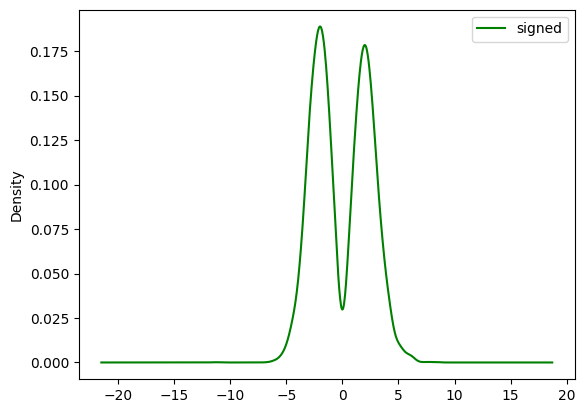

In [ ]:
#percentile_95_xg["Y_5_log_1"].plot.kde(label="log",color='r')
#percentile_95_xg["Y_5"].plot.kde(label="y5",color='b')
percentile_95_xg["signed_sqrt_Y_5"].plot.kde(label="signed",color='g')
plt.legend()

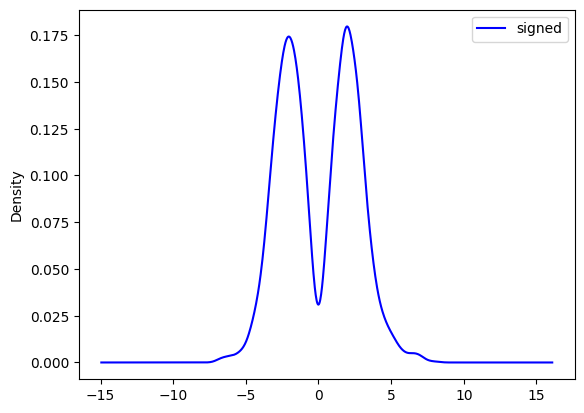

In [ ]:
#percentile_95_cb["Y_5_log_1"].plot.kde(label="cb",color='b')
percentile_95_cb["signed_sqrt_Y_5"].plot.kde(label="signed",color='b')
plt.legend()

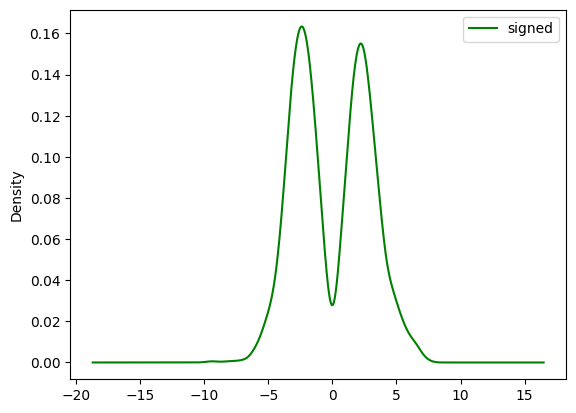

In [ ]:
#percentile_95_lg["Y_5_log_1"].plot.kde(label="lg",color='g')
percentile_95_lg["signed_sqrt_Y_5"].plot.kde(label="signed",color='g')
plt.legend()

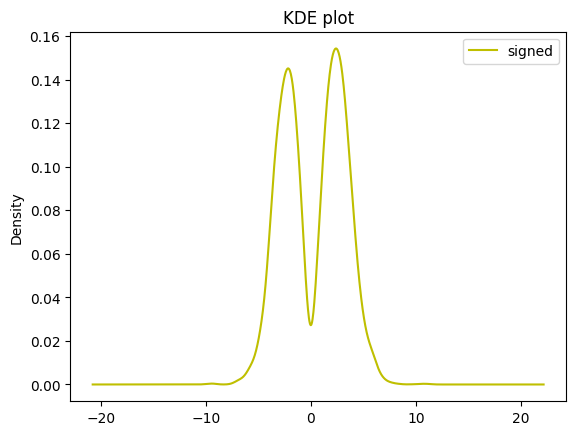

In [ ]:
#percentile_95_df["Y_5"].plot.kde(label="No-log")
#percentile_95_hist["Y_5_log_1"].plot.kde(label="hist",color='y')
percentile_95_hist["signed_sqrt_Y_5"].plot.kde(label="signed",color='y')
plt.title('KDE plot')
plt.legend()

# Data augmentation
- In this function, original_df represents your original time series dataset, and percentile_95_df represents the dataset containing values greater than the 95th percentile.

- You define the parameters augmentation_factor, which determines the proportion of augmented samples to generate, and noise_std, which controls the standard deviation of the added noise.

- Next, you call the augment_data function, passing in original_df, percentile_95_df, augmentation_factor, and noise_std as the function arguments. The function will return the augmented dataset, which you can store in the augmented_df variable.

- After obtaining the augmented dataset, you can use it for further preprocessing, model training, or any other analysis you need to perform.

Remember to adjust the parameters (augmentation_factor and noise_std) based on your specific requirements and dataset characteristics.

# augmentation function explain

1. The augment_data function takes four parameters: original_df (the original dataframe), percentile_95_df (the 95th percentile dataframe), augmentation_factor (the factor by which the data will be augmented), and noise_std (the standard deviation of the noise to be added).

2. The function starts by excluding the timestamp column from the original dataframe to identify the columns that need augmentation.

3. The original dataframe (original_df) is then sorted based on the timestamp. This is done using sort_values method with the by parameter set to 'timestamp_column' (modify it according to your actual timestamp column name).

4. The original data points are added to the augmented dataset by concatenating the original dataframe with itself augmentation_factor + 1 times. This is achieved using pd.concat with the ignore_index parameter set to True.

5. The number of augmented samples to generate is computed by multiplying the length of the original dataframe by the augmentation_factor and taking the integer part.

6. The percentile_95_df is sorted based on the timestamp as well, similar to the step 3.

7. Random indices are selected from the percentile_95_df using np.random.choice, where the size of the selection is equal to num_augmented_samples. These indices determine which samples from the 95th percentile data will be augmented and added to the augmented dataset.

8. The selected samples from the percentile_95_df are repeated to match the number of augmented samples required. This is done by using percentile_95_df.loc[random_indices] and resetting the index using reset_index(drop=True).

9. Noise is added to the selected samples in each column to introduce variability. A random noise vector is generated using np.random.normal with mean 0 and noise_std as the standard deviation. The noise is then added to each column of the selected samples.

10. The augmented samples are added to the augmented dataset by concatenating them with the previously concatenated original dataframe. Again, pd.concat is used with ignore_index set to True.

11. Finally, the augmented dataframe is sorted based on the timestamp (timestamp_column) to ensure the time sequence is preserved properly.

12. The augmented dataframe is returned as the output of the function.

*This function generates augmented data by replicating and augmenting a subset of the 95th percentile data, while preserving the time sequence of the original and augmented dataframes.*

In [ ]:
### time sequence keep
def augment_data(original_df, percentile_95_df, augmentation_factor, noise_std):
    # Excluding the timestamp column
    columns_to_augment = original_df.columns[1:]

    # Sort the original dataframe based on the timestamp
    original_df = original_df.sort_values(by='timestamp_column')

    # Add original data points to augmented dataset
    augmented_df = pd.concat([original_df] * (int(augmentation_factor) + 1), ignore_index=True)

    # Compute the number of augmented samples to generate
    num_augmented_samples = int(len(original_df) * augmentation_factor)

    # Sort the percentile_95_df based on the timestamp
    percentile_95_df = percentile_95_df.sort_values(by='timestamp_column')

    # Randomly select indices from the 95th percentile dataset
    random_indices = np.random.choice(percentile_95_df.index, num_augmented_samples)

    # Repeat the selected samples from the 95th percentile dataset
    augmented_samples = percentile_95_df.loc[random_indices].reset_index(drop=True)

    # Add noise to the selected samples
    for column in columns_to_augment:
        noise = np.random.normal(0, noise_std, size=len(augmented_samples))
        augmented_samples[column] += noise

    # Add the augmented samples to the augmented dataset
    augmented_df = pd.concat([augmented_df, augmented_samples], ignore_index=True)

    # Sort the augmented dataframe based on the timestamp
    augmented_df = augmented_df.sort_values(by='timestamp_column')

    return augmented_df

In [ ]:
print(df_xg.shape)
print(percentile_95_xg.shape)

(2461695, 13)
(46878, 13)


In [ ]:
print(df_cb.shape)
print(percentile_95_cb.shape)

(2786681, 13)
(53150, 13)


In [ ]:
print(df_lg.shape)
print(percentile_95_lg.shape)

(3001400, 13)
(30226, 13)


In [ ]:
print(df_hist.shape)
print(percentile_95_hist.shape)

(3329517, 13)
(33789, 13)


# Noise & Augmentation-Factor

In [ ]:
# Define the augmentation factor and noise standard deviation
augmentation_factor = 0.5  # Set the desired augmentation factor
noise_std = 0.1  # Set the desired standard deviation of noise

# augmented xg

In [ ]:
# Call the `augment_data` function with the excluded columns
augmented_xg = augment_data(df_xg, percentile_95_xg, augmentation_factor, noise_std)
print(augmented_xg.shape)

(3692542, 13)


# augmented cb

In [ ]:
# Call the `augment_data` function with the excluded columns
augmented_cb = augment_data(df_cb, percentile_95_cb, augmentation_factor, noise_std)
print(augmented_cb.shape)

(4180021, 13)


# augmented lg

In [ ]:
# Call the `augment_data` function with the excluded columns
augmented_lg = augment_data(df_lg, percentile_95_lg, augmentation_factor, noise_std)
print(augmented_lg.shape)

(4502100, 13)


# augmented hist

In [ ]:
# Call the `augment_data` function with the excluded columns
augmented_hist = augment_data(df_hist, percentile_95_hist, augmentation_factor, noise_std)
print(augmented_hist.shape)

(4994275, 13)


**augmentation_factor**
- When augmentation_factor = 2.0, it means that the size of the augmented dataset will be twice the size of the original dataset. The value of augmentation_factor determines the proportion of augmented samples to generate relative to the original dataset.

- For example, if your original dataset has 100 samples and you set augmentation_factor = 2.0, the augmented dataset will have an additional 200 samples (twice the size of the original dataset).

- By adjusting the augmentation_factor, you can control the amount of augmentation and the resulting size of the augmented dataset. Higher values of augmentation_factor will generate more augmented samples, increasing the dataset's size, while lower values will generate fewer augmented samples.

**noise_std**
- When noise_std = 0.1, it means that Gaussian noise with a standard deviation of 0.1 will be added to the augmented samples. The value of noise_std controls the magnitude or amplitude of the added noise.

- In the augment_data function, we generate the Gaussian noise using np.random.normal(0, noise_std, len(augmented_sample)). Here, the mean of the Gaussian distribution is 0, and the standard deviation is noise_std.

- By adjusting the value of noise_std, you can control the amount of noise added to the augmented samples. A higher noise_std will result in a larger range of random noise values added to the data, introducing more variability. Conversely, a lower noise_std will result in smaller variations, generating less noisy samples.

- The purpose of adding noise is to simulate and capture the inherent uncertainty or variability present in the data. It can help make the model more robust by exposing it to different patterns and variations within the data.

Remember to choose an appropriate noise_std value depending on the characteristics of your dataset and the desired level of noise addition. Experimentation and fine-tuning may be needed to determine the suitable value for your specific task.

In [ ]:
# prompt: count registers number by timestamp_column in augmented_df group by month
print(augmented_xg.groupby(augmented_xg['timestamp_column'].dt.month)['timestamp_column'].count())

In [ ]:
# prompt: count registers number by timestamp_column in augmented_df group by month
print(augmented_cb.groupby(augmented_cb['timestamp_column'].dt.month)['timestamp_column'].count())

timestamp_column
4    1169481
5    1619315
6    1391225
Name: timestamp_column, dtype: int64


In [ ]:
# prompt: count registers number by timestamp_column in augmented_df group by month
print(augmented_lg.groupby(augmented_lg['timestamp_column'].dt.month)['timestamp_column'].count())

In [ ]:
# prompt: count registers number by timestamp_column in augmented_df group by month
print(augmented_hist.groupby(augmented_hist['timestamp_column'].dt.month)['timestamp_column'].count())

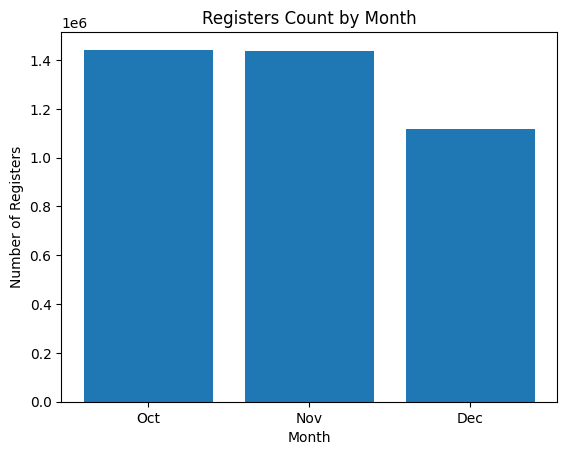

In [ ]:
  # prompt: count registers number by timestamp_column in augmented_df group by month and plot with month names
# Group data by month
monthly_counts = augmented_hist.groupby(augmented_hist['timestamp_column'].dt.month)['timestamp_column'].count()

# Get month names
month_names = calendar.month_abbr[10:13]

# Create bar plot
plt.bar(month_names, monthly_counts)
plt.xlabel('Month')
plt.ylabel('Number of Registers')
plt.title('Registers Count by Month')
plt.show()

# Save Augmented Data bases

In [ ]:
augmented_xg.to_csv('/content/drive/MyDrive/monobot/DeafReload/Trial2/data/augmented_xb_trial2.csv', index=False)
augmented_cb.to_csv('/content/drive/MyDrive/monobot/DeafReload/Trial2/data/augmented_cb_trial2.csv', index=False)
augmented_lg.to_csv('/content/drive/MyDrive/monobot/DeafReload/Trial2/data/augmented_lg_trial2.csv', index=False)
augmented_hist.to_csv('/content/drive/MyDrive/monobot/DeafReload/Trial2/data/augmented_hist_trial2.csv', index=False)

# Read augmented data

In [ ]:
augmented_xg = pd.read_csv('/content/drive/MyDrive/monobot/DeafReload/Trial2/data/augmented_xb_trial2.csv')
print(augmented_xg.shape)
augmented_cb = pd.read_csv('/content/drive/MyDrive/monobot/DeafReload/Trial2/data/augmented_cb_trial2.csv')
print(augmented_cb.shape)
augmented_lg = pd.read_csv('/content/drive/MyDrive/monobot/DeafReload/Trial2/data/augmented_lg_trial2.csv')
print(augmented_lg.shape)
augmented_hist = pd.read_csv('/content/drive/MyDrive/monobot/DeafReload/Trial2/data/augmented_hist_trial2.csv')
print(augmented_hist.shape)

(2954034, 12)
(3344017, 12)
(3601680, 12)
(3995420, 12)


In [ ]:
#timestamp-column
#augmented_xg['timestamp_column'] = pd.to_datetime(augmented_xg['timestamp_column'])
augmented_cb['timestamp_column'] = pd.to_datetime(augmented_cb['timestamp_column'])
#augmented_lg['timestamp_column'] = pd.to_datetime(augmented_lg['timestamp_column'])
#augmented_hist['timestamp_column'] = pd.to_datetime(augmented_hist['timestamp_column'])

# Features Engeenireing AD

In [ ]:
# Specify the columns that contain NaN values
columns_to_convert = ['topWick','body',	'bottomWick','ticks','spread','open','high','low','close','signed_sqrt_Y_5']

In [ ]:
# Convert columns with NaN values to numeric format
for column in columns_to_convert:
    augmented_xg[column] = pd.to_numeric(augmented_xg[column])

In [ ]:
# Convert columns with NaN values to numeric format
for column in columns_to_convert:
    augmented_cb[column] = pd.to_numeric(augmented_cb[column])

In [ ]:
# Convert columns with NaN values to numeric format
for column in columns_to_convert:
    augmented_lg[column] = pd.to_numeric(augmented_lg[column])

In [ ]:
# Convert columns with NaN values to numeric format
for column in columns_to_convert:
    augmented_hist[column] = pd.to_numeric(augmented_hist[column])

In [ ]:
augmented_hist.describe(percentiles=[0.8,0.90,0.95]).round(2)

,open,high,low,close,ticks,spread,topWick,body,bottomWick,Y_5_log_1,Y_5,signed_sqrt_Y_5
count,4994275.00,4994275.00,4994275.00,4994275.00,4994275.00,4994275.00,4994275.00,4994275.00,4994275.00,4994275.00,4994275.00,4994275.00
mean,1.02,1.02,1.02,1.02,5.29,40.24,0.32,4.19,0.29,0.39,0.40,0.09
std,0.07,0.07,0.07,0.07,4.09,92.60,1.29,6.79,1.22,8.23,8.33,2.35
min,0.51,0.49,0.48,0.53,1.00,0.00,-0.49,0.00,-0.52,-111.68,-108.20,-10.40
50%,1.02,1.02,1.02,1.02,4.00,7.00,0.00,1.00,0.00,0.10,0.10,0.32
80%,1.06,1.06,1.06,1.06,9.83,24.05,0.06,7.93,0.06,5.00,5.10,2.26
90%,1.07,1.07,1.07,1.07,11.16,172.00,1.00,11.10,1.00,8.66,8.80,2.97
95%,1.12,1.12,1.12,1.12,12.96,285.18,2.00,14.98,1.98,12.88,13.01,3.61
max,1.53,1.53,1.52,1.55,27.00,2800.24,63.19,564.22,76.23,130.58,130.76,11.69


# Create *data-variable* Dataset

In [ ]:
#drop nan if is any
#augmented_xg_nn = augmented_xg.dropna() #1
augmented_cb_nn = augmented_cb.dropna() #2
#augmented_lg_nn = augmented_lg.dropna() #3
#augmented_hist_nn = augmented_hist.dropna() #4

In [ ]:
#change data bases before for "base_for_features"
base_for_features = augmented_cb_nn.copy() #i

In [ ]:
#create variable of data name to only chance one time
data_variable = base_for_features.copy()

# Random Noises

In [ ]:
# 2 new noise variables from normal and uniform distribution
#data_variable['noise_normal'] = np.random.normal(0, 1, size=data_variable.shape[0])
#data_variable['noise_uniform'] = np.random.uniform(0, 1, size=data_variable.shape[0])

# Datetime features

In [ ]:
# prompt: create new featires from datetime variable
data_variable['hour'] = data_variable['timestamp_column'].apply(lambda x: x.hour)
data_variable['day'] = data_variable['timestamp_column'].apply(lambda x: x.day)
data_variable['month'] = data_variable['timestamp_column'].apply(lambda x: x.month)
#data['year'] = data['datetime'].apply(lambda x: x.year)

# Lags

## body lags

In [ ]:
# prompt: create lags from body, ticks and spead features
data_variable['body_1'] = data_variable['body'].shift(one_min)
data_variable['body_2'] = data_variable['body'].shift(two_min)
data_variable['body_3'] = data_variable['body'].shift(three_min)
data_variable['body_4'] = data_variable['body'].shift(four_min)
data_variable['body_5'] = data_variable['body'].shift(five_min)
data_variable['body_10'] = data_variable['body'].shift(ten_min)
data_variable['body_15'] = data_variable['body'].shift(fifteen_min)
data_variable['body_20'] = data_variable['body'].shift(twenty_min)
data_variable['body_25'] = data_variable['body'].shift(twentyfive_min)
data_variable['body_30'] = data_variable['body'].shift(thirty_min)
data_variable['body_40'] = data_variable['body'].shift(fourty_min)
data_variable['body_60'] = data_variable['body'].shift(sixty_min)

## ticks lags

In [ ]:
#for ticks
data_variable['ticks_1'] = data_variable['ticks'].shift(one_min)
data_variable['ticks_2'] = data_variable['ticks'].shift(two_min)
data_variable['ticks_3'] = data_variable['ticks'].shift(three_min)
data_variable['ticks_4'] = data_variable['ticks'].shift(four_min)
data_variable['ticks_5'] = data_variable['ticks'].shift(five_min)
data_variable['ticks_10'] = data_variable['ticks'].shift(ten_min)
data_variable['ticks_15'] = data_variable['ticks'].shift(fifteen_min)
data_variable['ticks_20'] = data_variable['ticks'].shift(twenty_min)
data_variable['ticks_25'] = data_variable['ticks'].shift(twentyfive_min)
data_variable['ticks_30'] = data_variable['ticks'].shift(thirty_min)
data_variable['ticks_40'] = data_variable['ticks'].shift(fourty_min)
data_variable['ticks_60'] = data_variable['ticks'].shift(sixty_min)

## spread lags

In [ ]:
#for spread
data_variable['spread_1'] = data_variable['spread'].shift(one_min)
data_variable['spread_2'] = data_variable['spread'].shift(two_min)
data_variable['spread_3'] = data_variable['spread'].shift(three_min)
data_variable['spread_4'] = data_variable['spread'].shift(four_min)
data_variable['spread_5'] = data_variable['spread'].shift(five_min)
data_variable['spread_10'] = data_variable['spread'].shift(ten_min)
data_variable['spread_15'] = data_variable['spread'].shift(fifteen_min)
data_variable['spread_20'] = data_variable['spread'].shift(twenty_min)
data_variable['spread_25'] = data_variable['spread'].shift(twentyfive_min)
data_variable['spread_30'] = data_variable['spread'].shift(thirty_min)
data_variable['spread_40'] = data_variable['spread'].shift(fourty_min)
data_variable['spread_60'] = data_variable['spread'].shift(sixty_min)

In [ ]:
# prompt: statistics transformation for spread,body and ticks features
data_variable['spread_log'] = np.log(data_variable['spread']+1)
data_variable['body_log'] = np.log(data_variable['body']+1)
data_variable['ticks_log'] = np.log(data_variable['ticks']+1)

In [ ]:
# prompt: Square Root Transformation for spread,body and ticks
data_variable['spread_sqrt'] = np.sqrt(data_variable['spread'])
data_variable['body_sqrt'] = np.sqrt(data_variable['body'])
data_variable['ticks_sqrt'] = np.sqrt(data_variable['ticks'])

In [ ]:
# prompt: Interaction Terms
data_variable['spread_x_body'] = data_variable['spread'] * data_variable['body']
data_variable['spread_x_ticks'] = data_variable['spread'] * data_variable['ticks']
data_variable['body_x_ticks'] = data_variable['body'] * data_variable['ticks']

In [ ]:
data_variable.shape

(4180021, 61)

# Save bases for models

In [ ]:
#save base
#data_variable.to_csv('/content/drive/MyDrive/monobot/DeafReload/Trial2/data/base_for_model_xg_trial2.csv', index=False) #for xg
#data_variable.to_csv('/content/drive/MyDrive/monobot/DeafReload/Trial2/data/base_for_model_cb_trial2.csv', index=False) #for cb
#data_variable.to_csv('/content/drive/MyDrive/monobot/DeafReload/Trial2/data/base_for_model_lg_trial2.csv', index=False) #for lg
#data_variable.to_csv('/content/drive/MyDrive/monobot/DeafReload/Trial2/data/base_for_model_hist_trial2.csv', index=False) #for hist

# Read Bases for models

In [ ]:
#data_variable_xg = pd.read_csv('/content/drive/MyDrive/monobot/DeafReload/Trial2/data/base_for_model_xg_trial2.csv')
data_variable_xg = data_variable.copy()
#data_variable_xg.to_csv('data_variable_xg.csv',index = False)
#print(data_variable_xg.shape)

In [ ]:
data_variable_xg = pd.read_csv('data_variable_xg.csv')
print(data_variable_xg.shape)

(3692542, 61)


In [ ]:
#data_variable_cb = pd.read_csv('/content/drive/MyDrive/monobot/DeafReload/Trial2/data/base_for_model_cb_trial2.csv')
data_variable_cb = data_variable.copy()
#print(data_variable_cb.shape)

In [ ]:
data_variable_cb.to_csv('data_variable_cb.csv',index = False)

In [ ]:
#data_variable_lg = pd.read_csv('/content/drive/MyDrive/monobot/DeafReload/Trial2/data/base_for_model_lg_trial2.csv')
data_variable_lg = data_variable.copy()
#print(data_variable_lg.shape)

In [ ]:
data_variable_lg.to_csv('data_variable_lg.csv',index = False)

In [ ]:
#data_variable_hist = pd.read_csv('/content/drive/MyDrive/monobot/DeafReload/Trial2/data/base_for_model_hist_trial2.csv')
data_variable_hist = data_variable.copy()
#print(data_variable_hist.shape)

In [ ]:
data_variable_hist.to_csv('data_variable_hist.csv',index = False)

# Voting Method 2 (PICK)

In [ ]:
print(data_variable.shape)

(7142382, 60)


In [ ]:
data_variable.columns.tolist()

['timestamp_column',
 'open',
 'high',
 'low',
 'close',
 'ticks',
 'spread',
 'topWick',
 'body',
 'bottomWick',
 'Y_5_log_1',
 'Y_5',
 'hour',
 'day',
 'month',
 'body_1',
 'body_2',
 'body_3',
 'body_4',
 'body_5',
 'body_10',
 'body_15',
 'body_20',
 'body_25',
 'body_30',
 'body_40',
 'body_60',
 'ticks_1',
 'ticks_2',
 'ticks_3',
 'ticks_4',
 'ticks_5',
 'ticks_10',
 'ticks_15',
 'ticks_20',
 'ticks_25',
 'ticks_30',
 'ticks_40',
 'ticks_60',
 'spread_1',
 'spread_2',
 'spread_3',
 'spread_4',
 'spread_5',
 'spread_10',
 'spread_15',
 'spread_20',
 'spread_25',
 'spread_30',
 'spread_40',
 'spread_60',
 'spread_log',
 'body_log',
 'ticks_log',
 'spread_sqrt',
 'body_sqrt',
 'ticks_sqrt',
 'spread_x_body',
 'spread_x_ticks',
 'body_x_ticks']

In [ ]:
df_sample = data_variable.dropna()

In [ ]:
X = df_sample.drop(['timestamp_column', 'Y_5','Y_5_log_2', 'high', 'low'], axis=1)
y = df_sample['Y_5_log_2']

In [ ]:
# Standardize the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Create the feature selection method
#feature_selector = VarianceThreshold(threshold=0.01)
feature_selector = SelectPercentile(score_func=f_regression, percentile=30)

In [ ]:
# Create the individual regressor models
linear_model = LinearRegression()
ridge_model = Ridge(alpha=1.0)
decision_tree = DecisionTreeRegressor()

In [ ]:
# Create the voting regressor with different models
voting_regressor = VotingRegressor([('linear', linear_model), ('ridge', ridge_model), ('tree', decision_tree)])

In [ ]:
# Fit the feature selector on the standardized input data
X_selected = feature_selector.fit_transform(X_scaled, y)

In [ ]:
# Fit the voting regressor on the selected features
voting_regressor.fit(X_selected, y)

VotingRegressor(estimators=[('linear', LinearRegression()), ('ridge', Ridge()),
                            ('tree', DecisionTreeRegressor())])

In [ ]:
# Get the indices of the selected features
feature_indices = feature_selector.get_support(indices=True)

In [ ]:
# Get the selected feature names
selected_feature_names = X.columns[feature_indices]

In [ ]:
# Get the voting values of the selected features
voting_values = voting_regressor.predict(X_selected)

In [ ]:
# Determine the minimum length among the arrays
min_length = min(len(selected_feature_names), len(voting_values))

In [ ]:
# Create a new DataFrame with the selected feature names and voting values
results_df = pd.DataFrame({'Feature': selected_feature_names[:min_length], 'VotingValue': voting_values[:min_length]})

In [ ]:
# prompt: sort values
results_df.sort_values('VotingValue', ascending=False)

,Feature,VotingValue
8,ticks_20,0.000519
11,spread_5,0.000481
15,spread_x_body,0.000341
6,ticks_4,0.000270
3,body_5,0.000267
14,spread_sqrt,0.000248
4,body_10,0.000230
9,ticks_25,0.000152
12,spread_15,0.000135
16,spread_x_ticks,0.000117


<Axes: ylabel='Feature'>

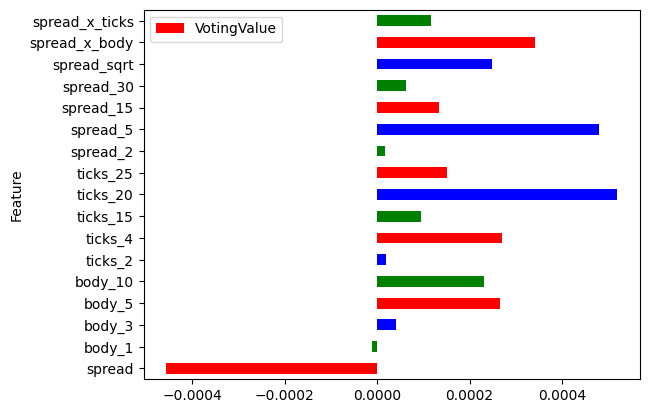

In [ ]:
results_df.plot.barh(x='Feature', y='VotingValue', color=['red', 'green', 'blue'])

# Models

#### **Model Methodology Explained:**

1. Outer Cross-Validation (TimeSeriesSplit): The dataset (X_train_cv_final and Y_train_cv) is split into training and validation sets using TimeSeriesSplit. In each iteration of the outer cross-validation loop, a different split of the data is used. The loop iterates 10 times (n_splits=10), meaning there will be 10 different training and validation sets.

2. Inner Cross-Validation (TimeSeriesSplit) and Hyperparameter Tuning: Inside the outer cross-validation loop, another TimeSeriesSplit is created to perform inner cross-validation for hyperparameter tuning. This inner cross-validation is done using a fixed train-validation split within each outer fold. In this case, n_splits=3 is used for the inner cross-validation, meaning three different splits of the training set are used.

3. LightGBM Regression Model: A LightGBM regressor (lgb.LGBMRegressor) is initialized as the base model for hyperparameter tuning.

3. RandomizedSearchCV: RandomizedSearchCV is used to perform hyperparameter tuning. It takes the initialized LightGBM regressor, a parameter grid (param_grid), and the inner cross-validation (inner_cv) as inputs. It performs random search over the parameter grid and evaluates the models using mean absolute percentage error ("neg_mean_absolute_percentage_error") as the scoring metric. Only one iteration (n_iter=1) is used in this example for the sake of brevity. The job is run in parallel using multiple cores (n_jobs=-1) and the verbosity level is set to 2 (verbose=2) for printing progress updates.

4. Best Model Selection: After the hyperparameter tuning is complete, the best model found during RandomizedSearchCV is extracted using lgb_random.best_estimator_.

5. Training Time: At the end of each iteration of the outer cross-validation loop, the training time of the current iteration is calculated and printed.

**Summary:**
*Nested cross-validation is performed to evaluate the performance of a LightGBM regression model with hyperparameter tuning. The outer loop splits the dataset into multiple training and validation sets and loops through them. In each outer loop iteration, an inner cross-validation loop is performed to tune the hyperparameters of the model using RandomizedSearchCV. The best model from hyperparameter tuning is selected and training time is tracked and printed. This process allows for a comprehensive evaluation of the model's performance and helps to select the best hyperparameters.*



In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
# Import XGBoost
from xgboost import XGBRegressor
# Import CatBoost
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error, explained_variance_score, mean_absolute_percentage_error
from google.colab import data_table
from sklearn.metrics import r2_score
from sklearn.metrics import median_absolute_error
import time
import joblib
data_table.enable_dataframe_formatter()

In [ ]:
# to model optimization
def mean_directional_accuracy(y_true, y_pred):
    y_true_sign = np.sign(y_true)
    y_pred_sign = np.sign(y_pred)
    directional_accuracy = np.mean(y_true_sign == y_pred_sign)
    return directional_accuracy

# Create a scoring function for Mean Directional Accuracy
scorer_mda = make_scorer(mean_directional_accuracy)

# Define the scoring metrics to be used
scoring_metrics = {
    "Neg Mean Absolute Error": "neg_mean_absolute_error",
    "Neg Mean Squared Error": "neg_mean_squared_error",
    "Explained Variance Score": "explained_variance",
    "Mean Directional Accuracy": scorer_mda
}

In [ ]:
df_xg_to_model = data_variable_xg.copy()
print(df_xg_to_model.shape)

(3692542, 61)


In [ ]:
df_cb_to_model = data_variable_cb.copy()
print(df_cb_to_model.shape)

(4180021, 61)


In [ ]:
df_lg_to_model = data_variable_lg.copy()
print(df_lg_to_model.shape)

(4502100, 61)


In [ ]:
df_hist_to_model = data_variable_hist.copy()
print(df_hist_to_model.shape)

(4994275, 61)


In [ ]:
#drop nan
df_xg_to_model = df_xg_to_model.dropna()
df_cb_to_model = df_cb_to_model.dropna()
df_lg_to_model = df_lg_to_model.dropna()
df_hist_to_model = df_hist_to_model.dropna()

# Split data

In [ ]:
common_feat = ['timestamp_column','topWick','body','bottomWick','spread','hour','day','month','body_3','body_5','body_20','ticks_2','ticks_4','ticks_5',
               'ticks_15','ticks_60','spread_5','spread_log','body_log','ticks_log','spread_sqrt','body_sqrt','Y_5_log_1','signed_sqrt_Y_5']

In [ ]:
df_xg_to_model = df_xg_to_model[common_feat]
df_cb_to_model = df_cb_to_model[common_feat]
df_lg_to_model = df_lg_to_model[common_feat]
df_hist_to_model = df_hist_to_model[common_feat]

In [ ]:
print(df_xg_to_model.timestamp_column.head(1))
print(df_xg_to_model.timestamp_column.tail(1))

print(df_cb_to_model.timestamp_column.head(1))
print(df_cb_to_model.timestamp_column.tail(1))

print(df_lg_to_model.timestamp_column.head(1))
print(df_lg_to_model.timestamp_column.tail(1))

print(df_hist_to_model.timestamp_column.head(1))
print(df_hist_to_model.timestamp_column.tail(1))

0   2022-01-03 18:46:02
Name: timestamp_column, dtype: datetime64[ns]
2458455   2022-03-31 21:42:14
Name: timestamp_column, dtype: datetime64[ns]
0   2022-04-04 00:05:35
Name: timestamp_column, dtype: datetime64[ns]
2783080   2022-06-30 21:07:19
Name: timestamp_column, dtype: datetime64[ns]
0   2022-07-04 00:05:55
Name: timestamp_column, dtype: datetime64[ns]
2997927   2022-09-30 21:59:15
Name: timestamp_column, dtype: datetime64[ns]
0   2022-10-03 00:05:40
Name: timestamp_column, dtype: datetime64[ns]
3326081   2022-12-30 21:53:16
Name: timestamp_column, dtype: datetime64[ns]


# Common Test Data

In [ ]:
df_to_test = test_data[common_feat]

In [ ]:
print(df_to_test.timestamp_column.head(1))
print(df_to_test.timestamp_column.tail(1))

0   2023-12-21 16:40:08
Name: timestamp_column, dtype: datetime64[ns]
721856   2024-01-19 21:14:30
Name: timestamp_column, dtype: datetime64[ns]


# Same test data

In [ ]:
######################################## COMMON TEST DATA SET#############################################################
df_test = df_to_test[(df_to_test["timestamp_column"]>=("2023-12-21 16:40:08"))]

## train/valid Xgboost

In [ ]:
#############################################################Train/Valid/Test XGBOOST###################################################################
df_train_xg = df_xg_to_model[(df_xg_to_model["timestamp_column"]>=("2022-01-03 18:46:02")) & (df_xg_to_model["timestamp_column"]<="2022-03-30 00:00:00")]
df_valid_xg = df_xg_to_model[(df_xg_to_model["timestamp_column"]>("2022-03-30 00:00:00"))]
print(df_train_xg.shape,"train data size")
print(df_valid_xg.shape,"valid data size")

(3530601, 24) train data size
(158341, 24) valid data size


## train/valid Catboost

In [ ]:
#############################################################Train/Valid/Test CATBOOSTING ###################################################################
df_train_cb = df_cb_to_model[(df_cb_to_model["timestamp_column"]>=("2022-04-04 00:00:00")) & (df_cb_to_model["timestamp_column"]<="2022-06-29 00:00:00")]
df_valid_cb = df_cb_to_model[(df_cb_to_model["timestamp_column"]>("2022-06-29 00:00:00"))]
print(df_train_cb.shape,"train data size")
print(df_valid_cb.shape,"valid data size")

(4072833, 61) train data size
(107188, 61) valid data size


## train/valid Lightgbm

In [ ]:
#############################################################Train/Valid/Test LIGHTGBM ###################################################################
df_train_lg = df_lg_to_model[(df_lg_to_model["timestamp_column"]>=("2022-07-04 00:00:00")) & (df_lg_to_model["timestamp_column"]<="2022-09-29 00:00:00")]
df_valid_lg = df_lg_to_model[(df_lg_to_model["timestamp_column"]>("2022-09-29 00:00:00"))]
print(df_train_lg.shape,"train data size")
print(df_valid_lg.shape,"valid data size")

(4330822, 24) train data size
(167678, 24) valid data size


## train/valid Histgradient

In [ ]:
#############################################################Train/Valid/Test HISTGRADIENTBOOSTING############################################################
df_train_hist = df_hist_to_model[(df_hist_to_model["timestamp_column"]>=("2022-10-03 00:00:00")) & (df_hist_to_model["timestamp_column"]<="2022-12-29 00:00:00")]
df_valid_hist = df_hist_to_model[(df_hist_to_model["timestamp_column"]>("2022-12-29 00:00:00"))]
print(df_train_hist.shape,"train data size")
print(df_valid_hist.shape,"valid data size")

(4901094, 24) train data size
(89581, 24) valid data size


In [ ]:
print(df_train_hist.timestamp_column.head(1),"train data start")
print(df_train_hist.timestamp_column.tail(1),"train data end")

0   2022-10-03 00:05:40
Name: timestamp_column, dtype: datetime64[ns] train data start
3240435   2022-12-28 23:55:01
Name: timestamp_column, dtype: datetime64[ns] train data end


# Train-Validation-Y

In [ ]:
#global
#df_train = df_train_xg
#df_valid = df_valid_xg

df_train = df_train_cb
df_valid = df_valid_cb
#
#df_train = df_train_lg
#df_valid = df_valid_lg
#
#df_train = df_train_hist
#df_valid = df_valid_hist

In [ ]:
##Model configuration xg
Y_train_cv, X_train_cv = df_train.signed_sqrt_Y_5, df_train
Y_validation, X_validation = df_valid.signed_sqrt_Y_5, df_valid

In [ ]:
Xs = X_train_cv.columns.to_list()

In [ ]:
X_train_cv_final = df_train[Xs]
#inner_cv_groups = X_train_cv_final["date_time_1"]
X_train_cv_final.drop(["timestamp_column",'signed_sqrt_Y_5','Y_5_log_1'], axis=1, inplace=True)

In [ ]:
X_validation_final = X_validation[Xs]
#outer_cv_groups = X_validation_final["datetime"]
X_validation_final.drop(["timestamp_column",'signed_sqrt_Y_5','Y_5_log_1'], axis=1, inplace=True)

In [ ]:
print(X_train_cv_final.shape)
print(Y_train_cv.shape)

(4072833, 58)
(4072833,)


In [ ]:
X_train_cv_final.columns.to_list()

['open',
 'high',
 'low',
 'close',
 'ticks',
 'spread',
 'topWick',
 'body',
 'bottomWick',
 'Y_5',
 'hour',
 'day',
 'month',
 'body_1',
 'body_2',
 'body_3',
 'body_4',
 'body_5',
 'body_10',
 'body_15',
 'body_20',
 'body_25',
 'body_30',
 'body_40',
 'body_60',
 'ticks_1',
 'ticks_2',
 'ticks_3',
 'ticks_4',
 'ticks_5',
 'ticks_10',
 'ticks_15',
 'ticks_20',
 'ticks_25',
 'ticks_30',
 'ticks_40',
 'ticks_60',
 'spread_1',
 'spread_2',
 'spread_3',
 'spread_4',
 'spread_5',
 'spread_10',
 'spread_15',
 'spread_20',
 'spread_25',
 'spread_30',
 'spread_40',
 'spread_60',
 'spread_log',
 'body_log',
 'ticks_log',
 'spread_sqrt',
 'body_sqrt',
 'ticks_sqrt',
 'spread_x_body',
 'spread_x_ticks',
 'body_x_ticks']

# ***1. XGBoost***

## Param Grid

In [ ]:
param_grid = {
    'learning_rate': [1.3],
    'max_depth': [16],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'n_estimators': [100],
    'gamma': [0],
    'min_child_weight': [200],
    'reg_alpha': [0],
    'reg_lambda': [0, 0.1]
}

- learning_rate: Learning rate controls the step size at each boosting iteration. A smaller learning rate makes the model learning slower but can help prevent overfitting.

- max_depth: Maximum depth of a tree. A higher value can allow the model to capture more complex relationships, but deep trees may overfit.

- subsample: Subsample ratio of the training instances. It defines the proportion of samples used for training each tree. A lower value can prevent overfitting by introducing randomness.

- colsample_bytree: Subsample ratio of columns (features) when constructing each tree. Similar to subsample, it introduces randomness by selecting a subset of features for training each tree.

- n_estimators: Number of boosting rounds (trees) to build. A higher value can lead to a more powerful model but increases training time.

- gamma: Minimum loss reduction required for a further split. A higher value promotes more conservative tree pruning, reducing overfitting.

- min_child_weight: Minimum sum of instance weight needed in a child for it to be considered for splitting. Higher values prevent overfitting by adding more conservatism.

- reg_alpha: L1 regularization term on the weights. It encourages sparsity in the feature space and can help reduce overfitting.

- reg_lambda: L2 regularization term on the weights. It helps prevent overfitting by adding a penalty term to the loss function.

- scale_pos_weight: Control the balance of positive and negative weights in the dataset. It is useful for imbalanced classification tasks.

## Train XGBoost

In [ ]:
# Define the number of splits for rolling window cross-validation
n_splits = 3

# Set the random seed for reproducibility
random_seed = 42

# Initialize rolling window time series split
rolling_cv = TimeSeriesSplit(n_splits=n_splits)

best_mda = 0
best_model = None

# Outer cross-validation with rolling window
for train_index, test_index in rolling_cv.split(X_train_cv_final):
    X_train, X_test = X_train_cv_final.iloc[train_index], X_train_cv_final.iloc[test_index]
    y_train, y_test = Y_train_cv.iloc[train_index], Y_train_cv.iloc[test_index]

    # Track training time
    start_time = time.time()

    # Inner cross-validation with TimeSeriesSplit
    inner_cv = TimeSeriesSplit(n_splits=2)

    # Create XGBoost regressor
    xgb_model = XGBRegressor()

    # Perform RandomizedSearchCV with inner CV
    xgb_random = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_grid,
        cv=inner_cv,
        n_iter=1,
        scoring=scoring_metrics,
        refit="Neg Mean Absolute Error",
        n_jobs=-1,
        verbose=2,
        random_state=random_seed
    )
    xgb_random.fit(X_train, y_train)

    # Best model from hyperparameter tuning
    best_xgboost = xgb_random.best_estimator_

    # Calculate and print training time
    end_time = time.time()
    training_time = end_time - start_time
    print("Training time:", training_time)

    # Evaluate on the validation set using different scoring metrics
    y_pred = best_xgboost.predict(X_test)

    # Calculate scoring metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    evs = explained_variance_score(y_test, y_pred)
    mda = mean_directional_accuracy(y_test, y_pred)

    print("Validation Set Evaluation:")
    print("Neg Mean Absolute Error:", -mae)
    print("Neg Mean Squared Error:", -mse)
    print("Explained Variance Score:", evs)
    print("Mean Directional Accuracy:", mda)

    # Check if this model has the best MDA so far
    if mda > best_mda:
        best_mda = mda
        best_model = best_xgboost

# Print the best model
print("Best Model:")
print(best_model)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Training time: 28.296484231948853
Validation Set Evaluation:
Neg Mean Absolute Error: -2.664045021254704
Neg Mean Squared Error: -11.522030629267867
Explained Variance Score: -1.4871518537885642
Mean Directional Accuracy: 0.49987197643460035
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Training time: 46.266358852386475
Validation Set Evaluation:
Neg Mean Absolute Error: -3.060702531784215
Neg Mean Squared Error: -15.201984021155186
Explained Variance Score: -1.6289671993602068
Mean Directional Accuracy: 0.5105228573047074
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Training time: 72.60215163230896
Validation Set Evaluation:
Neg Mean Absolute Error: -2.55427377951899
Neg Mean Squared Error: -10.819663066666953
Explained Variance Score: -1.4398017371584806
Mean Directional Accuracy: 0.49603353537642325
Best Model:
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylev

## Test XGBoost

In [ ]:
y_test_pred_xg = best_xgboost.predict(df_test[X_train_cv_final.columns])

NameError: name 'X_train_cv_final' is not defined

In [ ]:
result_test_xg=df_test.Y_5_log_1.to_frame().copy()
result_test_xg=df_test.copy()
result_test_xg["timestamp_column"]=df_test.timestamp_column
result_test_xg["set_type"]='test'

In [ ]:
result_test_xg["pred_test_xb"]=y_test_pred_xg

In [ ]:
# Calculate mean absolute error
mae = mean_absolute_error(df_test.Y_5_log_1, y_test_pred_xg)

# Calculate mean squared error
mse = mean_squared_error(df_test.Y_5_log_1, y_test_pred_xg)

# Calculate explained variance score
evs = explained_variance_score(df_test.Y_5_log_1, y_test_pred_xg)

# Calculate mean directional accuracy
mda = np.mean(np.sign(df_test.Y_5_log_1) == np.sign(y_test_pred_xg))

# Print the metrics
print("Neg Mean Absolute Error:", -mae)
print("Neg Mean Squared Error:", -mse)
print("Explained Variance Score:", evs)
print("Mean Directional Accuracy:", mda)

Neg Mean Absolute Error: -2.99785386909214
Neg Mean Squared Error: -16.71207125017668
Explained Variance Score: -0.17850705330213668
Mean Directional Accuracy: 0.5010618446589837


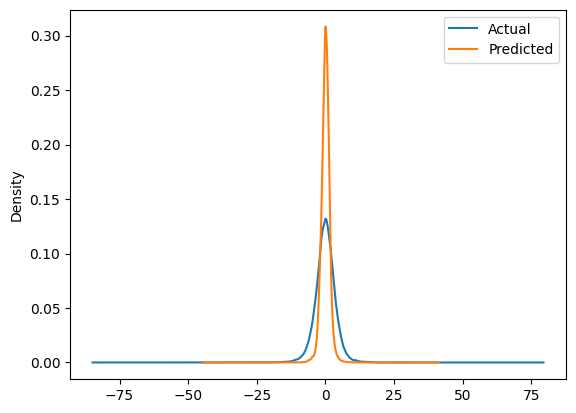

In [ ]:
result_test_xg["Y_5_log_1"].plot.kde(label="Actual")
result_test_xg["pred_test_xb"].plot.kde(label="Predicted")
plt.legend()

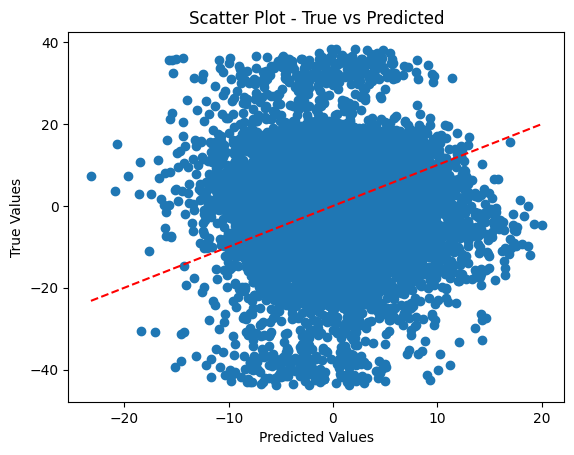

In [ ]:
# Assuming you have a dataframe called result_test_xg
true_label = result_test_xg['Y_5_log_1']
predicted_label = result_test_xg['pred_test_xb']

# Create the scatter plot
plt.scatter(predicted_label, true_label)

# Add a reference line with slope 1 for comparison
plt.plot([min(predicted_label), max(predicted_label)], [min(predicted_label), max(predicted_label)], color='red', linestyle='--')

# Add title and labels to the plot
plt.title('Scatter Plot - True vs Predicted')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')

# Display the plot
plt.show()

In [ ]:
result_test_xg[["Y_5_log_1","signed_sqrt_Y_5","pred_test_xb"]].head(20)

,Y_5_log_1,signed_sqrt_Y_5,pred_test_xb
0,-0.636581,-0.836660,-2.595759
1,-0.545643,-0.774597,0.226981
2,-1.000332,-1.048809,-0.669927
3,-0.636581,-0.836660,-0.305848
4,-0.909430,-1.000000,0.506490
5,-1.546038,-1.303840,-0.246586
6,-1.727987,-1.378405,0.200160
7,-1.909898,-1.449138,-0.221545
8,-2.455584,-1.643168,0.422808
9,-2.455561,-1.643168,0.911568


# ***Save xb***

In [ ]:
filename = 'xg_model_signed_target_Q1.sav'
pickle.dump(best_xgboost, open(filename, 'wb'))

# ***2. CatBoost***

In [ ]:
# Define the parameter grid for CatBoostRegressor
param_grid = {
    'learning_rate': [0.9],
    'depth': [12],
    'subsample': [0.8],
    'colsample_bylevel': [0.8],
    'n_estimators': [250],
    'l2_leaf_reg': [1]
}

## Train CatBoost

In [ ]:
# Define the number of splits for rolling window cross-validation
n_splits = 3

# Set the random seed for reproducibility
random_seed = 425

# Initialize rolling window time series split
rolling_cv = TimeSeriesSplit(n_splits=n_splits)

best_model = None

# Outer cross-validation with rolling window
for train_index, test_index in rolling_cv.split(X_train_cv_final):
    X_train, X_test = X_train_cv_final.iloc[train_index], X_train_cv_final.iloc[test_index]
    y_train, y_test = Y_train_cv.iloc[train_index], Y_train_cv.iloc[test_index]

    # Track training time
    start_time = time.time()

    # Inner cross-validation with TimeSeriesSplit
    inner_cv = TimeSeriesSplit(n_splits=2)

    # Create CatBoost regressor
    catboost_model = CatBoostRegressor()

    # Perform RandomizedSearchCV with inner CV
    catboost_random = RandomizedSearchCV(
        estimator=catboost_model,
        param_distributions=param_grid,
        cv=inner_cv,
        n_iter=1,
        scoring=scoring_metrics,
        refit="Neg Mean Absolute Error",
        n_jobs=-1,
        verbose=2,
        random_state=random_seed
    )
    catboost_random.fit(X_train, y_train)

    # Best model from hyperparameter tuning
    best_catboost = catboost_random.best_estimator_

    # Calculate and print training time
    end_time = time.time()
    training_time = end_time - start_time
    print("Training time:", training_time)

    # Evaluate on the validation set using different scoring metrics
    y_pred = best_catboost.predict(X_test)

    # Calculate scoring metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    evs = explained_variance_score(y_test, y_pred)

    print("Validation Set Evaluation:")
    print("Neg Mean Absolute Error:", -mae)
    print("Neg Mean Squared Error:", -mse)
    print("Explained Variance Score:", evs)

    # Assign the latest best model
    best_model = best_catboost

# Print the best model
print("Best Model:")
print(best_model)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
0:	learn: 0.3552494	total: 317ms	remaining: 1m 18s
1:	learn: 0.2121909	total: 617ms	remaining: 1m 16s
2:	learn: 0.1785229	total: 924ms	remaining: 1m 16s
3:	learn: 0.1379005	total: 1.23s	remaining: 1m 15s
4:	learn: 0.1267177	total: 1.54s	remaining: 1m 15s
5:	learn: 0.1060181	total: 1.85s	remaining: 1m 15s
6:	learn: 0.0995658	total: 2.17s	remaining: 1m 15s
7:	learn: 0.0947265	total: 2.48s	remaining: 1m 14s
8:	learn: 0.0908688	total: 2.78s	remaining: 1m 14s
9:	learn: 0.0879498	total: 3.08s	remaining: 1m 13s
10:	learn: 0.0854874	total: 3.38s	remaining: 1m 13s
11:	learn: 0.0828364	total: 3.68s	remaining: 1m 12s
12:	learn: 0.0812402	total: 3.99s	remaining: 1m 12s
13:	learn: 0.0795380	total: 4.29s	remaining: 1m 12s
14:	learn: 0.0780683	total: 4.58s	remaining: 1m 11s
15:	learn: 0.0771921	total: 4.88s	remaining: 1m 11s
16:	learn: 0.0751437	total: 5.18s	remaining: 1m 10s
17:	learn: 0.0742790	total: 5.47s	remaining: 1m 10s
18:	learn: 0.07

## Test CatBoost

In [ ]:
y_test_pred_cb = best_catboost.predict(df_test[X_train_cv_final.columns])

KeyError: "['open', 'high', 'low', 'close', 'ticks', 'Y_5', 'body_1', 'body_2', 'body_4', 'body_10', 'body_15', 'body_25', 'body_30', 'body_40', 'body_60', 'ticks_1', 'ticks_3', 'ticks_10', 'ticks_20', 'ticks_25', 'ticks_30', 'ticks_40', 'spread_1', 'spread_2', 'spread_3', 'spread_4', 'spread_10', 'spread_15', 'spread_20', 'spread_25', 'spread_30', 'spread_40', 'spread_60', 'ticks_sqrt', 'spread_x_body', 'spread_x_ticks', 'body_x_ticks'] not in index"

In [ ]:
result_test_cb=df_test.Y_5_log_1.to_frame().copy()
result_test_cb=df_test.copy()
result_test_cb["timestamp_column"]=df_test.timestamp_column
result_test_cb["set_type"]='test'

In [ ]:
result_test_cb["pred_test_cb"]=y_test_pred_cb

NameError: name 'y_test_pred_cb' is not defined

In [ ]:
# Calculate mean absolute error
mae = mean_absolute_error(df_test.Y_5_log_1, y_test_pred_cb)

# Calculate mean squared error
mse = mean_squared_error(df_test.Y_5_log_1, y_test_pred_cb)

# Calculate explained variance score
evs = explained_variance_score(df_test.Y_5_log_1, y_test_pred_cb)

# Calculate mean directional accuracy
mda = np.mean(np.sign(df_test.Y_5_log_1) == np.sign(y_test_pred_cb))

# Print the metrics
print("Neg Mean Absolute Error:", -mae)
print("Neg Mean Squared Error:", -mse)
print("Explained Variance Score:", evs)
print("Mean Directional Accuracy:", mda)

Neg Mean Absolute Error: -2.9341421154286653
Neg Mean Squared Error: -16.097105160564578
Explained Variance Score: -0.13205994076428906
Mean Directional Accuracy: 0.5013303037770603


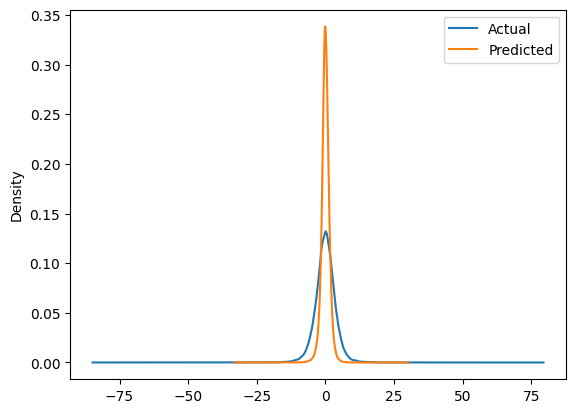

In [ ]:
result_test_cb["Y_5_log_1"].plot.kde(label="Actual")
result_test_cb["pred_test_cb"].plot.kde(label="Predicted")
plt.legend()

In [ ]:
result_test_cb[["Y_5_log_1","signed_sqrt_Y_5","pred_test_cb"]].head(20)

,Y_5_log_1,signed_sqrt_Y_5,pred_test_cb
0,-0.636581,-0.836660,-2.154609
1,-0.545643,-0.774597,-1.420500
2,-1.000332,-1.048809,-1.132201
3,-0.636581,-0.836660,-0.639487
4,-0.909430,-1.000000,-2.125773
5,-1.546038,-1.303840,1.989126
6,-1.727987,-1.378405,-1.820656
7,-1.909898,-1.449138,-0.625507
8,-2.455584,-1.643168,-1.298382
9,-2.455561,-1.643168,-1.049594


# *Save CatBoost*

In [ ]:
filename = 'cb_model_signed_target_Q2.sav'
pickle.dump(best_catboost, open(filename, 'wb'))

# ***3. Lightgbm***

## Param Grid lg

In [ ]:
# Hyperparameter grid for LightGBM
param_grid = {
    'learning_rate': [1.0],   # step size for each iteration in boosting
    'n_estimators': [350],  # number of trees or boosting rounds
    'num_leaves': [200],  # maximum number of leaves in full trees
    'max_depth': [16],  # maximum tree depth for base learners
    'min_child_samples': [5],  # minimum number of data needed in a child (leaf), equivalent to min_data_in_leaf from your previous grid
    'max_bin': [200],  # max number of bins that feature values will be bucketed in
    'subsample': [1],  # fraction of samples to be used for fitting the individual base learners, corresponds to bagging_fraction
    'colsample_bytree': [1],  # fraction of columns to be randomly sampled for each tree
    'reg_alpha': [0],  # L1 regularization term on weights
    'reg_lambda': [0.1]  # L2 regularization term on weights
}

## Train lg

**If preserving the sign of the predicted values is important for your final prediction**, you can consider using a metric that is specifically designed to evaluate the direction or sign of the predictions. One such metric is the Mean Directional Accuracy (MDA) or Directional Accuracy (DA).

- Mean Directional Accuracy (MDA) or Directional Accuracy (DA):

- The MDA or DA measures the proportion of predictions that correctly capture the direction (sign) of the true values.
- It calculates the percentage of predictions that have the same sign (up or down) as the true values.
- MDA ranges from 0 to 1, with higher values indicating better performance in capturing the sign direction.

In [ ]:
# Define the number of splits for rolling window cross-validation
n_splits = 3

random_seed = 4578

# Initialize rolling window time series split
rolling_cv = TimeSeriesSplit(n_splits=n_splits)

best_mda = 0
best_model = None

# Outer cross-validation with rolling window
for train_index, test_index in rolling_cv.split(X_train_cv_final):
    X_train, X_test = X_train_cv_final.iloc[train_index], X_train_cv_final.iloc[test_index]
    y_train, y_test = Y_train_cv.iloc[train_index], Y_train_cv.iloc[test_index]

    # Track training time
    start_time = time.time()

    # Inner cross-validation with TimeSeriesSplit
    inner_cv = TimeSeriesSplit(n_splits=2)

    # Create LightGBM regressor
    lgb_model = LGBMRegressor(force_row_wise=True)

    # Perform RandomizedSearchCV with inner CV
    lgb_random = RandomizedSearchCV(
        estimator=lgb_model,
        param_distributions=param_grid,
        cv=inner_cv,
        n_iter=1,
        scoring=scoring_metrics,
        refit="Neg Mean Absolute Error",
        n_jobs=-1,
        verbose=2,
        random_state = random_seed
    )
    lgb_random.fit(X_train, y_train)

    # Best model from hyperparameter tuning
    best_lightgbm  = lgb_random.best_estimator_

    # Calculate and print training time
    end_time = time.time()
    training_time = end_time - start_time
    print("Training time:", training_time)

    # Evaluate on the validation set using different scoring metrics
    y_pred = best_lightgbm.predict(X_test)

    # Calculate scoring metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    evs = explained_variance_score(y_test, y_pred)
    mda = mean_directional_accuracy(y_test, y_pred)

    print("Validation Set Evaluation:")
    print("Neg Mean Absolute Error:", -mae)
    print("Neg Mean Squared Error:", -mse)
    print("Explained Variance Score:", evs)
    print("Mean Directional Accuracy:", mda)

  # Check if this model has the best MDA so far
    if mda > best_mda:
        best_mda = mda
        best_model = best_lightgbm

# Print the best model
print("Best Model:")
print(best_model)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[LightGBM] [Info] Total Bins 3652
[LightGBM] [Info] Number of data points in the train set: 882651, number of used features: 21
[LightGBM] [Info] Start training from score -0.005787
Training time: 22.74488878250122
Validation Set Evaluation:
Neg Mean Absolute Error: -2.5834883270743205
Neg Mean Squared Error: -10.94276257411565
Explained Variance Score: -1.354831181686336
Mean Directional Accuracy: 0.4993927377782813
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[LightGBM] [Info] Total Bins 3658
[LightGBM] [Info] Number of data points in the train set: 1765301, number of used features: 21
[LightGBM] [Info] Start training from score -0.023678
Training time: 38.46332573890686
Validation Set Evaluation:
Neg Mean Absolute Error: -2.8321807489561417
Neg Mean Squared Error: -13.209430551561784
Explained Variance Score: -1.2386954256602425
Mean Directional Accuracy: 0.5127864952132782
Fitting 2 folds for each of 1 candida

## Test Set lgm

In [ ]:
y_test_pred_lg = best_lightgbm.predict(df_test[X_train_cv_final.columns])

In [ ]:
result_test_lg=df_test.Y_5_log_1.to_frame().copy()
result_test_lg=df_test.copy()
result_test_lg["timestamp_column"]=df_test.timestamp_column
result_test_lg["set_type"]='test'

In [ ]:
result_test_lg["pred_test_lg"]=y_test_pred_lg

In [ ]:
# Calculate mean absolute error
mae = mean_absolute_error(df_test.Y_5_log_1, y_test_pred_lg)

# Calculate mean squared error
mse = mean_squared_error(df_test.Y_5_log_1, y_test_pred_lg)

# Calculate explained variance score
evs = explained_variance_score(df_test.Y_5_log_1, y_test_pred_lg)

# Calculate mean directional accuracy
mda = np.mean(np.sign(df_test.Y_5_log_1) == np.sign(y_test_pred_lg))

# Print the metrics
print("Neg Mean Absolute Error:", -mae)
print("Neg Mean Squared Error:", -mse)
print("Explained Variance Score:", evs)
print("Mean Directional Accuracy:", mda)

Neg Mean Absolute Error: -2.7845424325294252
Neg Mean Squared Error: -14.631077762466207
Explained Variance Score: -0.028356493824198248
Mean Directional Accuracy: 0.5017772190177053


<Axes: title={'center': 'predicho vs real'}>

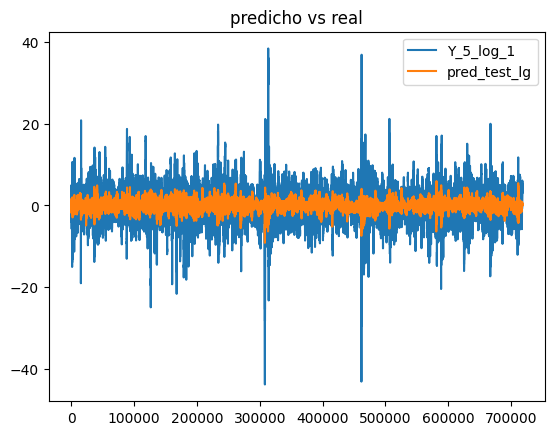

In [ ]:
result_test_lg[['Y_5_log_1','pred_test_lg']].plot(title="predicho vs real")

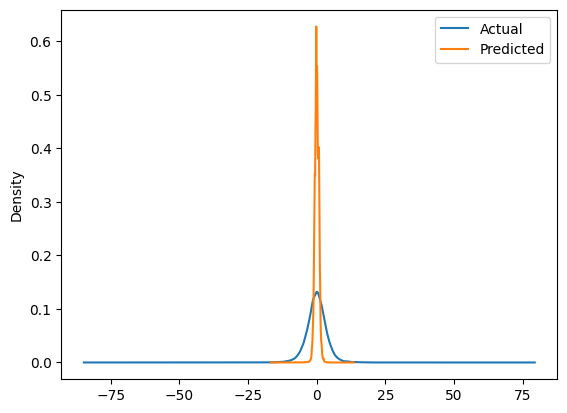

In [ ]:
result_test_lg["Y_5_log_1"].plot.kde(label="Actual")
result_test_lg["pred_test_lg"].plot.kde(label="Predicted")
plt.legend()

In [ ]:
result_test_lg[["Y_5_log_1","signed_sqrt_Y_5","pred_test_lg"]].head(20)

,Y_5_log_1,signed_sqrt_Y_5,pred_test_lg
0,-0.636581,-0.836660,0.646467
1,-0.545643,-0.774597,-0.583210
2,-1.000332,-1.048809,-0.647982
3,-0.636581,-0.836660,-0.698847
4,-0.909430,-1.000000,-0.714276
5,-1.546038,-1.303840,0.304874
6,-1.727987,-1.378405,-1.334338
7,-1.909898,-1.449138,-0.586297
8,-2.455584,-1.643168,-0.606346
9,-2.455561,-1.643168,-0.364325


# ***Save lg***

In [ ]:
filename = 'lg_model_log_target_Q3.sav'
pickle.dump(best_lightgbm, open(filename, 'wb'))

# ***4. HistGradientBoosting***

## Param Grid hist

In [ ]:
#from sklearn.experimental import enable_hist_gradient_boosting  # Required for HistGradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

In [ ]:
param_grid = {
    "learning_rate": [0.9],  # Rate at which trees learn
    "max_iter": [300],  # Maximum number of iterations (trees)
    "max_depth": [16],  # Maximum depth of each tree
    'max_leaf_nodes': [450],  # Higher maximum leaf nodes increase model complexity
    "min_samples_leaf": [1],  # Minimum samples required to be at a leaf node
    "max_bins": [200],  # Maximum number of bins for histogram construction
    "l2_regularization": [1.0],  # L2 regularization strength
    "early_stopping": [True],  # Stop training if validation score doesn't improve for several iterations
    "random_state": [42]  # Set random seed for reproducibility
}

## Train hist

In [ ]:
# Define the number of splits for rolling window cross-validation
n_splits = 3

random_seed = 5678

# Initialize rolling window time series split
rolling_cv = TimeSeriesSplit(n_splits=n_splits)

best_mda = 0  # Initialize the best MDA
best_model = None  # Initialize the best model

# Outer cross-validation with rolling window
for train_index, test_index in rolling_cv.split(X_train_cv_final):
    X_train, X_test = X_train_cv_final.iloc[train_index], X_train_cv_final.iloc[test_index]
    y_train, y_test = Y_train_cv.iloc[train_index], Y_train_cv.iloc[test_index]

    # Track training time
    start_time = time.time()

    # Inner cross-validation with TimeSeriesSplit
    inner_cv = TimeSeriesSplit(n_splits=2)

    # Create HistGradientBoostingRegressor
    hist_gradient_model = HistGradientBoostingRegressor()

    # Perform RandomizedSearchCV with inner CV
    hist_gradient_random = RandomizedSearchCV(
        estimator=hist_gradient_model,
        param_distributions=param_grid,
        cv=inner_cv,
        n_iter=1,
        scoring=scoring_metrics,
        refit="Neg Mean Absolute Error",
        n_jobs=-1,
        verbose=2,
        random_state = random_seed
    )
    hist_gradient_random.fit(X_train, y_train)

    # Best model from hyperparameter tuning
    best_hist_gradient = hist_gradient_random.best_estimator_

    # Calculate and print training time
    end_time = time.time()
    training_time = end_time - start_time
    print("Training time:", training_time)

    # Evaluate on the validation set using different scoring metrics
    y_pred = best_hist_gradient.predict(X_test)

    # Calculate scoring metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    evs = explained_variance_score(y_test, y_pred)
    mda = mean_directional_accuracy(y_test, y_pred)

    print("Validation Set Evaluation:")
    print("Neg Mean Absolute Error:", -mae)
    print("Neg Mean Squared Error:", -mse)
    print("Explained Variance Score:", evs)
    print("Mean Directional Accuracy:", mda)

    # Check if this model has the best MDA so far
    if mda > best_mda:
        best_mda = mda
        best_model = best_hist_gradient

# Print the best model
print("Best Model:")
print(best_model)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Training time: 14.099767923355103
Validation Set Evaluation:
Neg Mean Absolute Error: -2.2863294524012256
Neg Mean Squared Error: -8.232086843224627
Explained Variance Score: -0.777686438339271
Mean Directional Accuracy: 0.497368152721917
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Training time: 40.05764698982239
Validation Set Evaluation:
Neg Mean Absolute Error: -2.628350331434717
Neg Mean Squared Error: -11.045226581003208
Explained Variance Score: -0.8908826340569929
Mean Directional Accuracy: 0.5130855945165128
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Training time: 91.90544128417969
Validation Set Evaluation:
Neg Mean Absolute Error: -2.2392495265358106
Neg Mean Squared Error: -7.930008785484986
Explained Variance Score: -0.7881841647947683
Mean Directional Accuracy: 0.5022251175437603
Best Model:
HistGradientBoostingRegressor(early_stopping=True, l2_regularization=1.0,
                  

## Test Set hist

In [ ]:
y_test_pred_hist = best_hist_gradient.predict(df_test[X_train_cv_final.columns])

In [ ]:
result_test_hist=df_test.Y_5_log_1.to_frame().copy()
result_test_hist=df_test.copy()
result_test_hist["timestamp_column"]=df_test.timestamp_column
result_test_hist["set_type"]='test'

In [ ]:
result_test_hist["pred_test_hist"] = y_test_pred_hist

In [ ]:
# Calculate mean absolute error
mae = mean_absolute_error(df_test.Y_5_log_1, y_test_pred_hist)

# Calculate mean squared error
mse = mean_squared_error(df_test.Y_5_log_1, y_test_pred_hist)

# Calculate explained variance score
evs = explained_variance_score(df_test.Y_5_log_1, y_test_pred_hist)

# Calculate mean directional accuracy
mda = np.mean(np.sign(df_test.Y_5_log_1) == np.sign(y_test_pred_hist))

# Print the metrics
print("Neg Mean Absolute Error:", -mae)
print("Neg Mean Squared Error:", -mse)
print("Explained Variance Score:", evs)
print("Mean Directional Accuracy:", mda)

Neg Mean Absolute Error: -2.7724556833548126
Neg Mean Squared Error: -14.584936257163516
Explained Variance Score: -0.02563684473364547
Mean Directional Accuracy: 0.4969098804466925


<Axes: title={'center': 'predicho vs real'}>

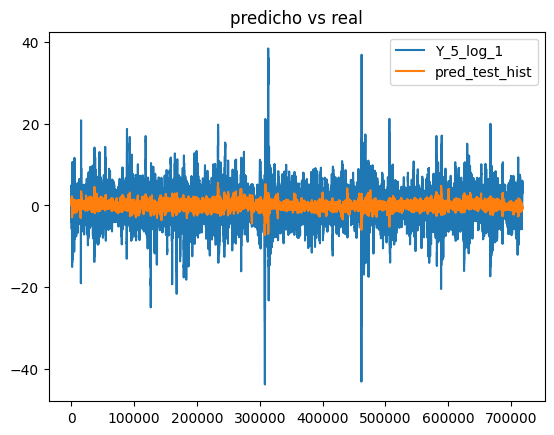

In [ ]:
result_test_hist[['Y_5_log_1','pred_test_hist']].plot(title="predicho vs real")

<Axes: ylabel='Density'>

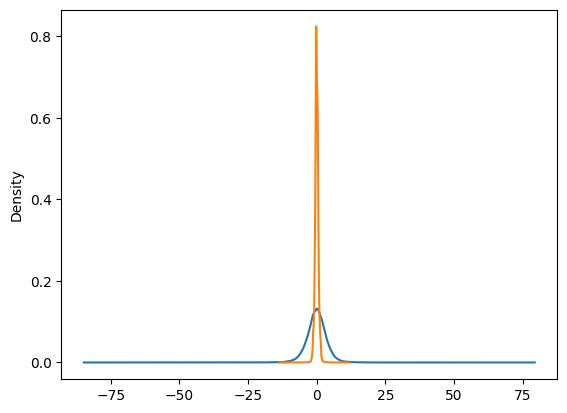

In [ ]:
result_test_hist["Y_5_log_1"].plot.kde(label="Actual")
result_test_hist["pred_test_hist"].plot.kde(label="pred")

In [ ]:
result_test_hist[["Y_5_log_1","signed_sqrt_Y_5","pred_test_hist"]].head(20)

,Y_5_log_1,signed_sqrt_Y_5,pred_test_hist
0,-0.636581,-0.836660,2.086930
1,-0.545643,-0.774597,-0.933152
2,-1.000332,-1.048809,0.406315
3,-0.636581,-0.836660,0.123355
4,-0.909430,-1.000000,0.450884
5,-1.546038,-1.303840,1.405559
6,-1.727987,-1.378405,1.362593
7,-1.909898,-1.449138,0.538988
8,-2.455584,-1.643168,0.444466
9,-2.455561,-1.643168,-0.179495


# ***Save hist***

In [ ]:
filename = 'hist_model_signed_target_Q4.sav'
pickle.dump(best_hist_gradient, open(filename, 'wb'))

# ***10. Super Learner***

In [ ]:
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

In [ ]:
filename_xg = 'xg_model_signed_target_Q1.sav'
filename_cb = 'cb_model_signed_target_Q2.sav'
filename_lg = 'lg_model_signed_target_Q3.sav'
filename_hist = 'hist_model_signed_target_Q4.sav'

In [ ]:
#load train models
best_xgboost = pickle.load(open(filename_xg, 'rb'))
best_catboost = pickle.load(open(filename_cb, 'rb'))
best_lightgbm = pickle.load(open(filename_lg, 'rb'))
best_hist_gradient = pickle.load(open(filename_hist, 'rb'))

In [ ]:
selected_feature_names = [
        'topWick',
        'body',
        'bottomWick',
        'spread',
        'hour',
        'day',
        'month',
        'body_3',
        'body_5',
        'body_20',
        'ticks_2',
        'ticks_4',
        'ticks_5',
        'ticks_15',
        'ticks_60',
        'spread_5',
        'spread_log',
        'body_log',
        'ticks_log',
        'spread_sqrt',
        'body_sqrt',
]

## Define X,y

In [ ]:
#Train/Valid/Test
X_train = df_22_23[(df_22_23["timestamp_column"]>=("2022-01-03 18:46:02")) & (df_22_23["timestamp_column"]<="2022-12-30 16:43:37")]
#df_test = df_to_model[(df_to_model["datetime"]>("2023-10-31 23:57:50")) & (df_to_model["datetime"]<="2023-12-08 23:29:17")]

In [ ]:
print(X_train.shape)
print(df_test.shape)

(11652765, 13)
(721857, 24)


In [ ]:
print(X_train.timestamp_column.head(1))
print(X_train.timestamp_column.tail(1))

0   2022-01-03 18:46:02
Name: timestamp_column, dtype: datetime64[ns]
11652764   2022-12-30 16:43:37
Name: timestamp_column, dtype: datetime64[ns]


In [ ]:
# prompt: create new featires from datetime variable
X_train['hour'] = X_train['timestamp_column'].apply(lambda x: x.hour)
X_train['day'] = X_train['timestamp_column'].apply(lambda x: x.day)
X_train['month'] = X_train['timestamp_column'].apply(lambda x: x.month)

<ipython-input-53-5740a3da6662>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['hour'] = X_train['timestamp_column'].apply(lambda x: x.hour)
<ipython-input-53-5740a3da6662>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['day'] = X_train['timestamp_column'].apply(lambda x: x.day)
<ipython-input-53-5740a3da6662>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [ ]:
# prompt: create lags from body, ticks and spead features
X_train['body_1'] = X_train['body'].shift(one_min)
X_train['body_2'] = X_train['body'].shift(two_min)
X_train['body_3'] = X_train['body'].shift(three_min)
X_train['body_4'] = X_train['body'].shift(four_min)
X_train['body_5'] = X_train['body'].shift(five_min)
X_train['body_10'] = X_train['body'].shift(ten_min)
X_train['body_15'] = X_train['body'].shift(fifteen_min)
X_train['body_20'] = X_train['body'].shift(twenty_min)
X_train['body_25'] = X_train['body'].shift(twentyfive_min)
X_train['body_30'] = X_train['body'].shift(thirty_min)
X_train['body_40'] = X_train['body'].shift(fourty_min)
X_train['body_60'] = X_train['body'].shift(sixty_min)

<ipython-input-54-dd426b35e270>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['body_1'] = X_train['body'].shift(one_min)
<ipython-input-54-dd426b35e270>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['body_2'] = X_train['body'].shift(two_min)
<ipython-input-54-dd426b35e270>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

In [ ]:
#for ticks
X_train['ticks_1'] = X_train['ticks'].shift(one_min)
X_train['ticks_2'] = X_train['ticks'].shift(two_min)
X_train['ticks_3'] = X_train['ticks'].shift(three_min)
X_train['ticks_4'] = X_train['ticks'].shift(four_min)
X_train['ticks_5'] = X_train['ticks'].shift(five_min)
X_train['ticks_10'] = X_train['ticks'].shift(ten_min)
X_train['ticks_15'] = X_train['ticks'].shift(fifteen_min)
X_train['ticks_20'] = X_train['ticks'].shift(twenty_min)
X_train['ticks_25'] = X_train['ticks'].shift(twentyfive_min)
X_train['ticks_30'] = X_train['ticks'].shift(thirty_min)
X_train['ticks_40'] = X_train['ticks'].shift(fourty_min)
X_train['ticks_60'] = X_train['ticks'].shift(sixty_min)

<ipython-input-55-1ffb8a0faada>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['ticks_1'] = X_train['ticks'].shift(one_min)
<ipython-input-55-1ffb8a0faada>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['ticks_2'] = X_train['ticks'].shift(two_min)
<ipython-input-55-1ffb8a0faada>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [ ]:
#for spread
X_train['spread_1'] = X_train['spread'].shift(one_min)
X_train['spread_2'] = X_train['spread'].shift(two_min)
X_train['spread_3'] = X_train['spread'].shift(three_min)
X_train['spread_4'] = X_train['spread'].shift(four_min)
X_train['spread_5'] = X_train['spread'].shift(five_min)
X_train['spread_10'] = X_train['spread'].shift(ten_min)
X_train['spread_15'] = X_train['spread'].shift(fifteen_min)
X_train['spread_20'] = X_train['spread'].shift(twenty_min)
X_train['spread_25'] = X_train['spread'].shift(twentyfive_min)
X_train['spread_30'] = X_train['spread'].shift(thirty_min)
X_train['spread_40'] = X_train['spread'].shift(fourty_min)
X_train['spread_60'] = X_train['spread'].shift(sixty_min)

<ipython-input-56-e135a5abdc8d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['spread_1'] = X_train['spread'].shift(one_min)
<ipython-input-56-e135a5abdc8d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['spread_2'] = X_train['spread'].shift(two_min)
<ipython-input-56-e135a5abdc8d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

In [ ]:
# prompt: statistics transformation for spread,body and ticks features
X_train['spread_log'] = np.log(X_train['spread']+1)
X_train['body_log'] = np.log(X_train['body']+1)
X_train['ticks_log'] = np.log(X_train['ticks']+1)

<ipython-input-57-5c3f501d5056>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['spread_log'] = np.log(X_train['spread']+1)
<ipython-input-57-5c3f501d5056>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['body_log'] = np.log(X_train['body']+1)
<ipython-input-57-5c3f501d5056>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [ ]:
# prompt: Interaction Terms
X_train['spread_x_body'] = X_train['spread'] * X_train['body']
X_train['spread_x_ticks'] = X_train['spread'] * X_train['ticks']
X_train['body_x_ticks'] = X_train['body'] * X_train['ticks']

<ipython-input-58-51b2404b461c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['spread_x_body'] = X_train['spread'] * X_train['body']
<ipython-input-58-51b2404b461c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['spread_x_ticks'] = X_train['spread'] * X_train['ticks']
<ipython-input-58-51b2404b461c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [ ]:
# prompt: Square Root Transformation for spread,body and ticks
X_train['spread_sqrt'] = np.sqrt(X_train['spread'])
X_train['body_sqrt'] = np.sqrt(X_train['body'])
X_train['ticks_sqrt'] = np.sqrt(X_train['ticks'])

<ipython-input-59-f1a13caadcd2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['spread_sqrt'] = np.sqrt(X_train['spread'])
<ipython-input-59-f1a13caadcd2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['body_sqrt'] = np.sqrt(X_train['body'])
<ipython-input-59-f1a13caadcd2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [ ]:
X_train_ = X_train.dropna()
holdout = df_test.dropna()

In [ ]:
X_train_.columns

Index(['timestamp_column', 'open', 'high', 'low', 'close', 'ticks', 'spread',
       'topWick', 'body', 'bottomWick', 'Y_5_log_1', 'Y_5', 'signed_sqrt_Y_5',
       'hour', 'day', 'month', 'body_1', 'body_2', 'body_3', 'body_4',
       'body_5', 'body_10', 'body_15', 'body_20', 'body_25', 'body_30',
       'body_40', 'body_60', 'ticks_1', 'ticks_2', 'ticks_3', 'ticks_4',
       'ticks_5', 'ticks_10', 'ticks_15', 'ticks_20', 'ticks_25', 'ticks_30',
       'ticks_40', 'ticks_60', 'spread_1', 'spread_2', 'spread_3', 'spread_4',
       'spread_5', 'spread_10', 'spread_15', 'spread_20', 'spread_25',
       'spread_30', 'spread_40', 'spread_60', 'spread_log', 'body_log',
       'ticks_log', 'spread_x_body', 'spread_x_ticks', 'body_x_ticks',
       'spread_sqrt', 'body_sqrt', 'ticks_sqrt'],
      dtype='object')

In [ ]:
# Convert the index to datetime, if it is not already
X_train_.index = pd.to_datetime(X_train_.index)

In [ ]:
# Sort the dataframe based on the timestamp
X_train_ = X_train_.sort_index()

In [ ]:
# Set a seed for reproducibility (optional)
random_seed = 42
pd.np.random.seed(random_seed)

<ipython-input-64-379dc831544a>:3: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  pd.np.random.seed(random_seed)


In [ ]:
# Specify the desired sample percentage
sample_percentage = 0.5  # % of the data

In [ ]:
# Calculate the sample size as a percentage of the total number of rows
sample_size = int(len(X_train_) * sample_percentage)

In [ ]:
# Take a random sample of the dataframe while preserving the time sequence
X2 = X_train_.sample(n=sample_size)
print(X2.shape)

(5824582, 61)


In [ ]:
# Sort the sampled dataframe based on the timestamp (optional, but recommended)
X2 = X2.sort_index()

In [ ]:
print(X2.timestamp_column.head(1))
print(X2.timestamp_column.tail(1))

1970-01-01   2022-01-03 18:46:02
Name: timestamp_column, dtype: datetime64[ns]
1970-01-01 00:00:00.011649164   2022-12-30 15:28:57
Name: timestamp_column, dtype: datetime64[ns]


In [ ]:
X = X2[selected_feature_names].values
print(X.shape)
y = X2['signed_sqrt_Y_5'].values
print(y.shape)

(5824582, 21)
(5824582,)


## SL - Train Model

In [ ]:
# Step 1: Select a k-fold split of the training dataset
k = 3
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Step 2: Select m base-models or model configurations
m = 2
base_models = [best_xgboost,best_catboost,best_lightgbm, best_hist_gradient]

In [ ]:
# Step 3: For each basemodel
oof_preds = np.zeros((X.shape[0], len(base_models)))  # Store out-of-fold predictions

for i, model in enumerate(base_models):
    oof_model_preds = np.zeros(X.shape[0])  # Store out-of-fold predictions for current model

    # Step 3a: Evaluate using k-fold cross-validation
    for train_index, val_index in kf.split(X, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        cloned_model = clone(model)  # Create a fresh clone of the model
        cloned_model.fit(X_train, y_train)  # Fit the model on the training set

        val_preds = cloned_model.predict(X_val)  # Predict on the validation set
        oof_model_preds[val_index] = val_preds  # Store the predictions for this fold

    # Step 3b: Store all out-of-fold predictions
    oof_preds[:, i] = oof_model_preds

    # Step 3c: Fit the model on the full training dataset and store
    model.fit(X, y)

# Step 4: Fit a meta-model on the out-of-fold predictions
meta_model = LGBMRegressor(
    learning_rate=0.9,
    max_depth=12,
    max_iter=200,
    num_leaves=100,
    min_child_samples=5
)
meta_model.fit(oof_preds, y)

0:	learn: 1.9912090	total: 452ms	remaining: 1m 52s
1:	learn: 1.9867412	total: 826ms	remaining: 1m 42s
2:	learn: 1.9829477	total: 1.23s	remaining: 1m 41s
3:	learn: 1.9799381	total: 1.63s	remaining: 1m 40s
4:	learn: 1.9762871	total: 1.99s	remaining: 1m 37s
5:	learn: 1.9741054	total: 2.34s	remaining: 1m 35s
6:	learn: 1.9719283	total: 2.7s	remaining: 1m 33s
7:	learn: 1.9700135	total: 3.08s	remaining: 1m 33s
8:	learn: 1.9683919	total: 3.46s	remaining: 1m 32s
9:	learn: 1.9664008	total: 3.84s	remaining: 1m 32s
10:	learn: 1.9639841	total: 4.23s	remaining: 1m 31s
11:	learn: 1.9617809	total: 4.6s	remaining: 1m 31s
12:	learn: 1.9604040	total: 4.98s	remaining: 1m 30s
13:	learn: 1.9593561	total: 5.34s	remaining: 1m 30s
14:	learn: 1.9573622	total: 5.7s	remaining: 1m 29s
15:	learn: 1.9560734	total: 6.06s	remaining: 1m 28s
16:	learn: 1.9550400	total: 6.43s	remaining: 1m 28s
17:	learn: 1.9539481	total: 6.79s	remaining: 1m 27s
18:	learn: 1.9523990	total: 7.14s	remaining: 1m 26s
19:	learn: 1.9510044	tota

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=200, max_iter=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.129442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5824582, number of used features: 4
[LightGBM] [Info] Start training from score -0.014361


LGBMRegressor(learning_rate=0.9, max_depth=12, max_iter=200,
              min_child_samples=5, num_leaves=100)

In [ ]:
# Step 3: For each basemodel
#oof_preds = np.zeros((X.shape[0], len(base_models)))  # Store out-of-fold predictions
#
#for i, model in enumerate(base_models):
#    oof_model_preds = np.zeros(X.shape[0])  # Store out-of-fold predictions for current model
#
#    # Step 3a: Evaluate using k-fold cross-validation
#    for train_index, val_index in kf.split(X, y):
#        X_train, X_val = X[train_index], X[val_index]
#        y_train, y_val = y[train_index], y[val_index]
#
#        cloned_model = clone(model)  # Create a fresh clone of the model
#        cloned_model.fit(X_train, y_train)  # Fit the model on the training set
#
#        val_preds = cloned_model.predict(X_val)  # Predict on the validation set
#        oof_model_preds[val_index] = val_preds  # Store the predictions for this fold
#
#    # Step 3b: Store all out-of-fold predictions
#    oof_preds[:, i] = oof_model_preds
#
#    # Step 3c: Fit the model on the full training dataset and store
#    model.fit(X, y)
#
## Step 4: Fit a meta-model on the out-of-fold predictions
#from sklearn.ensemble import HistGradientBoostingRegressor
#meta_model = HistGradientBoostingRegressor(
#    learning_rate=0.1,
#    max_depth=8,
#    max_iter=100,
#    l2_regularization=0.1,
#    min_samples_leaf=10,
#    max_leaf_nodes=100,
#    early_stopping=True
#)
#meta_model.fit(oof_preds, y)

0:	learn: 5.3391067	total: 313ms	remaining: 2m 36s
1:	learn: 5.3049098	total: 630ms	remaining: 2m 36s
2:	learn: 5.2694616	total: 958ms	remaining: 2m 38s
3:	learn: 5.2371496	total: 1.29s	remaining: 2m 39s
4:	learn: 5.2198834	total: 1.6s	remaining: 2m 38s
5:	learn: 5.1993347	total: 1.9s	remaining: 2m 36s
6:	learn: 5.1872012	total: 2.21s	remaining: 2m 35s
7:	learn: 5.1698633	total: 2.54s	remaining: 2m 35s
8:	learn: 5.1574570	total: 2.86s	remaining: 2m 36s
9:	learn: 5.1528693	total: 3.19s	remaining: 2m 36s
10:	learn: 5.1376750	total: 3.47s	remaining: 2m 34s
11:	learn: 5.1291692	total: 3.77s	remaining: 2m 33s
12:	learn: 5.1192017	total: 4.09s	remaining: 2m 33s
13:	learn: 5.1109213	total: 4.39s	remaining: 2m 32s
14:	learn: 5.1032341	total: 4.74s	remaining: 2m 33s
15:	learn: 5.0963830	total: 5.13s	remaining: 2m 35s
16:	learn: 5.0885491	total: 5.49s	remaining: 2m 35s
17:	learn: 5.0803972	total: 5.84s	remaining: 2m 36s
18:	learn: 5.0723524	total: 6.14s	remaining: 2m 35s
19:	learn: 5.0681065	tot

HistGradientBoostingRegressor(early_stopping=True, l2_regularization=1.0,
                              max_depth=8, max_leaf_nodes=100,
                              min_samples_leaf=10)

In [ ]:
# Step 3: For each basemodel
#oof_preds = np.zeros((X.shape[0], len(base_models)))  # Store out-of-fold predictions
#
#for i, model in enumerate(base_models):
#    oof_model_preds = np.zeros(X.shape[0])  # Store out-of-fold predictions for current model
#
#    # Step 3a: Evaluate using k-fold cross-validation
#    for train_index, val_index in kf.split(X, y):
#        X_train, X_val = X[train_index], X[val_index]
#        y_train, y_val = y[train_index], y[val_index]
#
#        cloned_model = clone(model)  # Create a fresh clone of the model
#        cloned_model.fit(X_train, y_train)  # Fit the model on the training set
#
#        val_preds = cloned_model.predict(X_val)  # Predict on the validation set
#        oof_model_preds[val_index] = val_preds  # Store the predictions for this fold
#
#    # Step 3b: Store all out-of-fold predictions
#    oof_preds[:, i] = oof_model_preds
#
#    # Step 3c: Fit the model on the full training dataset and store
#    model.fit(X, y)
#
## Step 4: Fit a meta-model on the out-of-fold predictions
#meta_model = Ridge(alpha=1.0)
#meta_model.fit(oof_preds, y)

0:	learn: 5.3472821	total: 236ms	remaining: 1m 57s
1:	learn: 5.3151083	total: 400ms	remaining: 1m 39s
2:	learn: 5.2813328	total: 587ms	remaining: 1m 37s
3:	learn: 5.2472489	total: 753ms	remaining: 1m 33s
4:	learn: 5.2188927	total: 911ms	remaining: 1m 30s
5:	learn: 5.1826108	total: 1.07s	remaining: 1m 27s
6:	learn: 5.1561729	total: 1.25s	remaining: 1m 28s
7:	learn: 5.1318687	total: 1.43s	remaining: 1m 27s
8:	learn: 5.1154137	total: 1.6s	remaining: 1m 27s
9:	learn: 5.0940834	total: 1.78s	remaining: 1m 27s
10:	learn: 5.0801401	total: 1.94s	remaining: 1m 26s
11:	learn: 5.0737947	total: 2.14s	remaining: 1m 26s
12:	learn: 5.0596388	total: 2.29s	remaining: 1m 25s
13:	learn: 5.0439712	total: 2.47s	remaining: 1m 25s
14:	learn: 5.0295292	total: 2.62s	remaining: 1m 24s
15:	learn: 5.0201179	total: 2.76s	remaining: 1m 23s
16:	learn: 5.0035762	total: 2.9s	remaining: 1m 22s
17:	learn: 4.9950801	total: 3.04s	remaining: 1m 21s
18:	learn: 4.9849379	total: 3.17s	remaining: 1m 20s
19:	learn: 4.9689758	tot

Ridge()

In [ ]:
holdout_X = holdout[selected_feature_names].values

In [ ]:
holdout_X

array([[2.        , 0.        , 0.        , ..., 2.07944154, 3.46410162,
        0.        ],
       [0.        , 4.        , 0.        , ..., 1.94591015, 3.16227766,
        2.        ],
       [0.        , 2.        , 0.        , ..., 1.09861229, 1.41421356,
        1.41421356],
       ...,
       [0.        , 0.        , 0.        , ..., 1.38629436, 2.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 1.09861229, 1.73205081,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.69314718, 1.41421356,
        0.        ]])

In [ ]:
# Step 5: Evaluate the model on a holdout dataset or use model to make predictions
holdout_preds = np.zeros((holdout_X.shape[0], len(base_models)))  # Store predictions on holdout dataset

for i, model in enumerate(base_models):
    holdout_preds[:, i] = model.predict(holdout_X)

final_preds = meta_model.predict(holdout_preds)

# Evaluate the performance or use final_preds for further analysis

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [ ]:
final_preds.shape

(721857,)

## Validations

In [ ]:
# Split the data into training, hold-out validation, and test sets
X_train, X_holdout, y_train, y_holdout = train_test_split(oof_preds, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_holdout, y_holdout, test_size=0.5, random_state=42)

# Train the meta-model on the training set
meta_model.fit(X_train, y_train)

# Tune hyperparameters using the hold-out validation set
val_preds = meta_model.predict(X_val)

# Evaluate the performance on the hold-out validation set
val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))

# Make predictions on the test set
test_preds = meta_model.predict(X_test)

# Evaluate the performance on the test set
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 4659665, number of used features: 4
[LightGBM] [Info] Start training from score -0.014591
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [ ]:
val_rmse

1.8556338209665129

In [ ]:
test_rmse

1.855522133087751

# ***Save meta-model***

In [ ]:
filename = 'meta_hist_4_models_signed_target_Q1_to_Q4.sav'
pickle.dump(meta_model, open(filename, 'wb'))

In [ ]:
# Step 6: Save the trained meta-model
#joblib.dump(meta_model, "meta_model.pkl")

In [ ]:
#predictions stored in separate variables
preds_base_model1 = result_test_xg['pred_test_xb'].values
preds_base_model2 = result_test_cb['pred_test_cb'].values
preds_base_model3 = result_test_lg['pred_test_lg'].values
preds_base_model4 = result_test_hist['pred_test_hist'].values
#preds_base_model5 = result_test_svr['pred_test_svr'].values
#preds_base_model6 = result_test_knn['pred_test_knn'].values
#preds_base_model7 = result_test_ada['pred_test_ada'].values
#preds_base_model8 = result_test_bagg['pred_test_bagg'].values
#preds_base_model9 = result_test_extr['pred_test_extr'].values

NameError: name 'result_test_xg' is not defined

In [ ]:
preds_base_model3.shape

(809032,)

In [ ]:
# Create a dictionary to store the predictions
data = {
    'pred_model1': preds_base_model1,
    'pred_model2': preds_base_model2,
    'pred_model3': preds_base_model3,
    'pred_model4': preds_base_model4,
    #'pred_model5': preds_base_model5,
    #'pred_model6': preds_base_model6,
    #'pred_model7': preds_base_model7,
    #'pred_model8': preds_base_model8,
    #'pred_model9': preds_base_model9,
    'pred_meta_model': final_preds
}

In [ ]:
# Create a dataframe from the dictionary
predictions_df = pd.DataFrame(data)

In [ ]:
predictions_df.head(100)

,pred_model1,pred_model2,pred_model3,pred_model4,pred_meta_model
0,1.390460,-0.304786,0.043982,-2.013114,0.131867
1,-0.994009,-2.471739,-0.187381,-0.428108,-0.946374
2,1.863811,-0.136881,0.462876,0.335625,-0.939715
3,1.754616,-1.048803,-0.265536,-1.054676,-0.689878
4,2.859775,-1.914300,0.440369,-0.982299,-1.698105
...,...,...,...,...,...
95,0.624932,0.312021,-1.663238,-0.168416,-1.250500
96,1.981028,-0.808473,0.336584,-0.435076,-0.888308
97,1.846411,0.120422,0.497640,-0.051576,-1.691997
98,0.534561,-0.159806,0.313407,-0.214239,-0.488544


In [ ]:
# prompt: count negative vallues in each variable in predictions_df
print(predictions_df[predictions_df > 0].count(), "positive tendence")
print(predictions_df[predictions_df < 0].count(), "negative tendence")


pred_model1        378547
pred_model2        392886
pred_model3        385041
pred_model4        381290
pred_meta_model    414477
dtype: int64 positive tendence
pred_model1        430485
pred_model2        416146
pred_model3        423991
pred_model4        427742
pred_meta_model    394555
dtype: int64 negative tendence


# In Production

In [ ]:
import joblib

In [ ]:
# Load the saved models from the .pkl files
model1 = pickle.load(open('xg_model_log_target.sav', 'rb'))
model2 = pickle.load(open('cb_model_log_target.sav', 'rb'))
model3 = pickle.load(open('lg_model_log_target.sav', 'rb'))
model4 = pickle.load(open('hist_model_log_target.sav', 'rb'))
#model5 = pickle.load(open('svr_model_log_target.sav', 'rb'))
#model6 = pickle.load(open('knn_model_log_target.sav', 'rb'))
#model7 = pickle.load(open('ada_model_log_target.sav', 'rb'))
#model8 = pickle.load(open('bagging_model_model_log_target.sav', 'rb'))
#model9 = pickle.load(open('extree_model_log_target.sav', 'rb'))
meta_model = pickle.load(open('meta_4_models_log_target.sav', 'rb'))

In [ ]:
X_new_0 = holdout[selected_feature_names]
print(X_new_0.head(5))

   topWick  body  bottomWick  spread  hour  day  month  body_3  body_5  \
0        2     0           0    12.0    16   21     12     1.0     0.0   
1        0     4           0    10.0    16   21     12     0.0     1.0   
2        0     2           0     2.0    16   21     12     1.0     0.0   
3        0     1           0     4.0    16   21     12     0.0     0.0   
4        0     2           1     8.0    16   21     12     0.0     5.0   

   body_20  ...  ticks_4  ticks_5  ticks_15  ticks_60  spread_5  spread_log  \
0      2.0  ...     10.0      2.0       1.0       1.0       2.0    2.564949   
1      3.0  ...      3.0      4.0       6.0       5.0       5.0    2.397895   
2      4.0  ...      5.0      1.0       2.0       1.0       3.0    1.098612   
3      1.0  ...      5.0      1.0       4.0       2.0       1.0    1.609438   
4      1.0  ...      4.0      3.0       4.0       1.0       4.0    2.197225   

   body_log  ticks_log  spread_sqrt  body_sqrt  
0  0.000000   2.079442     3.46

In [ ]:
X_new = X_new_0.iloc[:1]

In [ ]:
# Assuming you have the new data stored in a variable called X_new
# Make predictions with each model
pred_model1 = model1.predict(X_new)
pred_model2 = model2.predict(X_new)
pred_model3 = model3.predict(X_new)
pred_model4 = model4.predict(X_new)
#pred_model5 = model5.predict(X_new)
#pred_model6 = model6.predict(X_new)
#pred_model7 = model7.predict(X_new)
#pred_model8 = model8.predict(X_new)
#pred_model9 = model9.predict(X_new)

In [ ]:
# Combine the predictions into a single array
base_model_preds = [pred_model1,pred_model2, pred_model3, pred_model4]
base_model_preds = np.array(base_model_preds).T

In [ ]:
base_model_preds

array([[ 1.39046049, -0.30478584,  0.04398171, -2.01311393]])

In [ ]:
# Make prediction with the meta-model
pred_meta_model = meta_model.predict(base_model_preds)

In [ ]:
# Print the final prediction from the meta-model
print(pred_meta_model)

[-1.72262318]


# Predict Full Data